In [227]:
# Importing main libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime
import yfinance as yf
import random

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.font_manager as fm


# Statistical Tests & Stats 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller, acf, pacf 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_lm, het_arch

# GARCH Model
from arch import arch_model
from scipy.stats import norm, skew, kurtosis, jarque_bera, norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Track computation time 
import time 

# Use pytorch to build and train NN 
import torch 
from torch import nn 
from torch.utils.data import DataLoader,TensorDataset,ConcatDataset
from torchview import draw_graph # Visualise models
import torch.optim as optim # Optimiser used for backpropagation

# Libraries for neural network / related tassks 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(
    context='paper',  
    font_scale=1,
    style='whitegrid',    
    palette='deep',      
)

In [3]:
def set_seed_all(seed=123):
    '''
    Make sure to call this each time if you want to optimise model params. Ie. to ensure best results are due to 
    param selection and not due to weight/bias initialisation. 
    '''
    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # Torch (CPU + GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Torch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

# 0. Helpful Functions

In [4]:
def plot_data(data, data_name,title_name,ax, hist = False):     
    if hist:  # If hist is True, plot a histogram
        sns.histplot(data, ax=ax, kde=False, color='blue' ,bins=50, stat = 'density')  # You can adjust 'bins' as needed
        ax.set_xlabel(data_name, fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.set_title(f'{title_name} (Histogram)', fontsize=16)
    else:  # Default case: plot a lineplot
        sns.lineplot(data=data, ax=ax, lw=2.5, color = 'blue' ,label=data_name)
        ax.set_ylabel(data_name, fontsize=14)
        ax.set_xlabel('Time', fontsize=14)  # Adjust xlabel as per your data
        ax.set_title(title_name, fontsize=16)
        ax.legend(loc='best', frameon=True, fontsize=16)


    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

In [5]:
set_seed_all()

# 1a. Preprocessing Data 

In [6]:
# Import in dataset 
# Import all data (Close, Open, High etc., just for future reference) with NA
df = yf.download("^GSPC", start = "1999-12-31", end = "2025-02-14", multi_level_index=False, keepna=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
spx_df = pd.DataFrame(df[['Close', 'High', 'Low']], index = df.index).dropna() 

In [8]:
spx_df.describe()

Close         High          Low
count  6319.000000  6319.000000  6319.000000
mean   2129.770896  2141.655827  2116.348761
std    1267.980380  1273.423322  1261.647379
min     676.530029   695.270020   666.789978
25%    1202.154968  1208.950012  1193.784973
50%    1494.819946  1505.339966  1486.959961
75%    2768.280029  2784.324951  2753.280029
max    6118.709961  6128.180176  6088.740234

In [9]:
spx_df.head()

Close         High          Low
Date                                             
1999-12-31  1469.250000  1472.420044  1458.189941
2000-01-03  1455.219971  1478.000000  1438.359985
2000-01-04  1399.420044  1455.219971  1397.430054
2000-01-05  1402.109985  1413.270020  1377.680054
2000-01-06  1403.449951  1411.900024  1392.099976

In [10]:
spx_df.tail()

Close         High          Low
Date                                             
2025-02-07  6025.990234  6101.279785  6019.959961
2025-02-10  6066.439941  6073.379883  6044.839844
2025-02-11  6068.500000  6076.279785  6042.339844
2025-02-12  6051.970215  6063.000000  6003.000000
2025-02-13  6115.069824  6116.910156  6050.950195

## 2a. Initial Feature Creation 

### 3a. Log Returns , Log Returns Squared and High Low Spread

In [11]:
# Log return function
log_return = lambda p: p.apply(np.log).diff(1)

In [12]:
returns = lambda p: p.diff(1)

In [13]:
spx_df['Returns'] = returns(spx_df['Close'])

In [14]:
# Create log returns and log returns squared
spx_df['Log Return'] = log_return(spx_df['Close'])
spx_df['Log Return Squared'] = spx_df['Log Return'] **2

In [15]:
spx_df['High Low Range'] = np.log(spx_df['High']) - np.log(spx_df['Low'])

In [16]:
spx_df = spx_df.drop(columns=['High', 'Low'])

In [17]:
crash_09_df = spx_df.loc['2007-12-01':'2009-06-01'] 

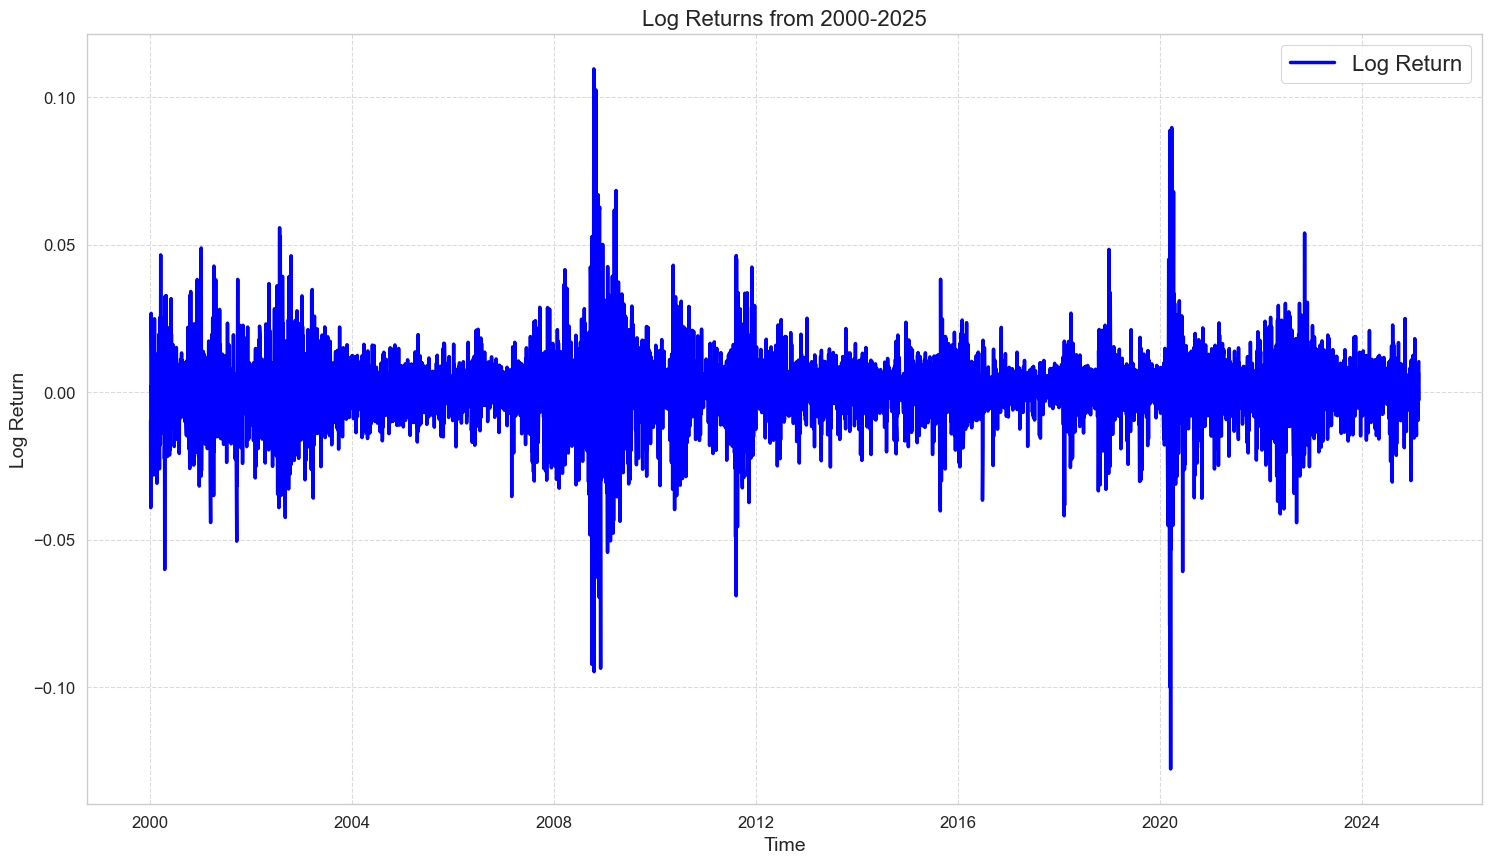

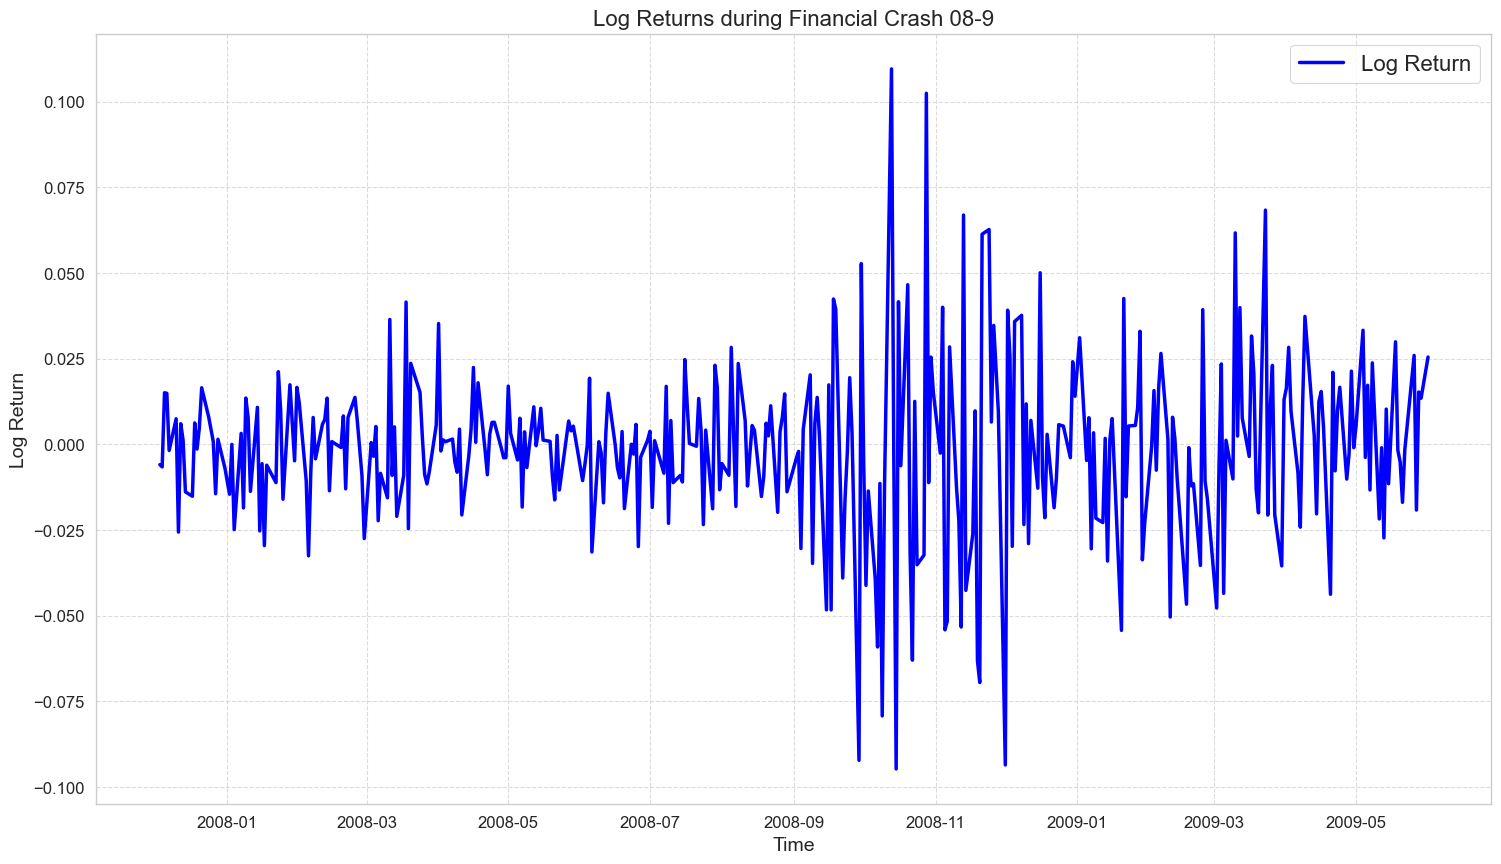

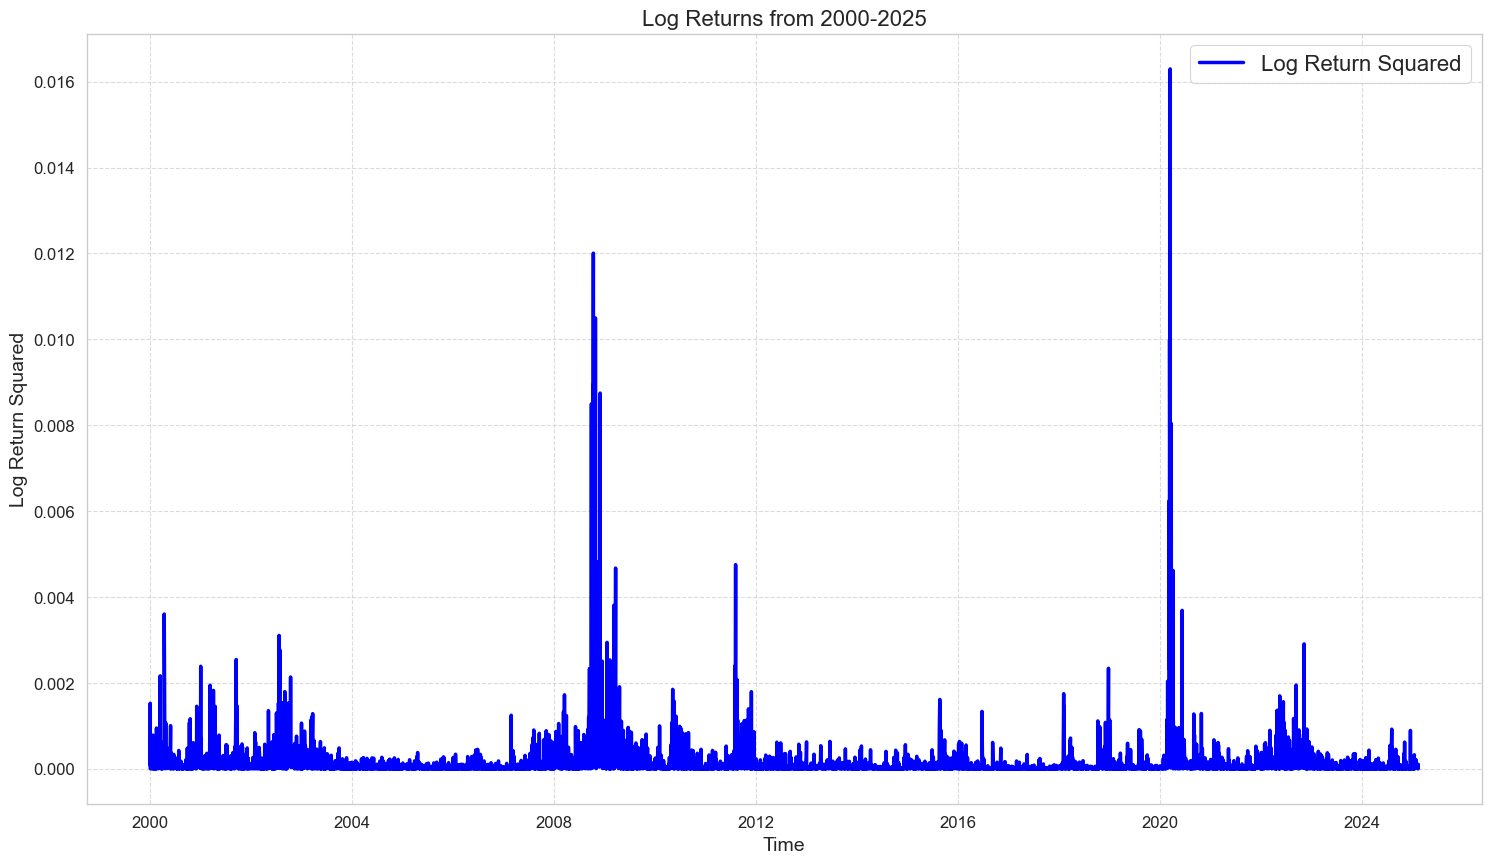

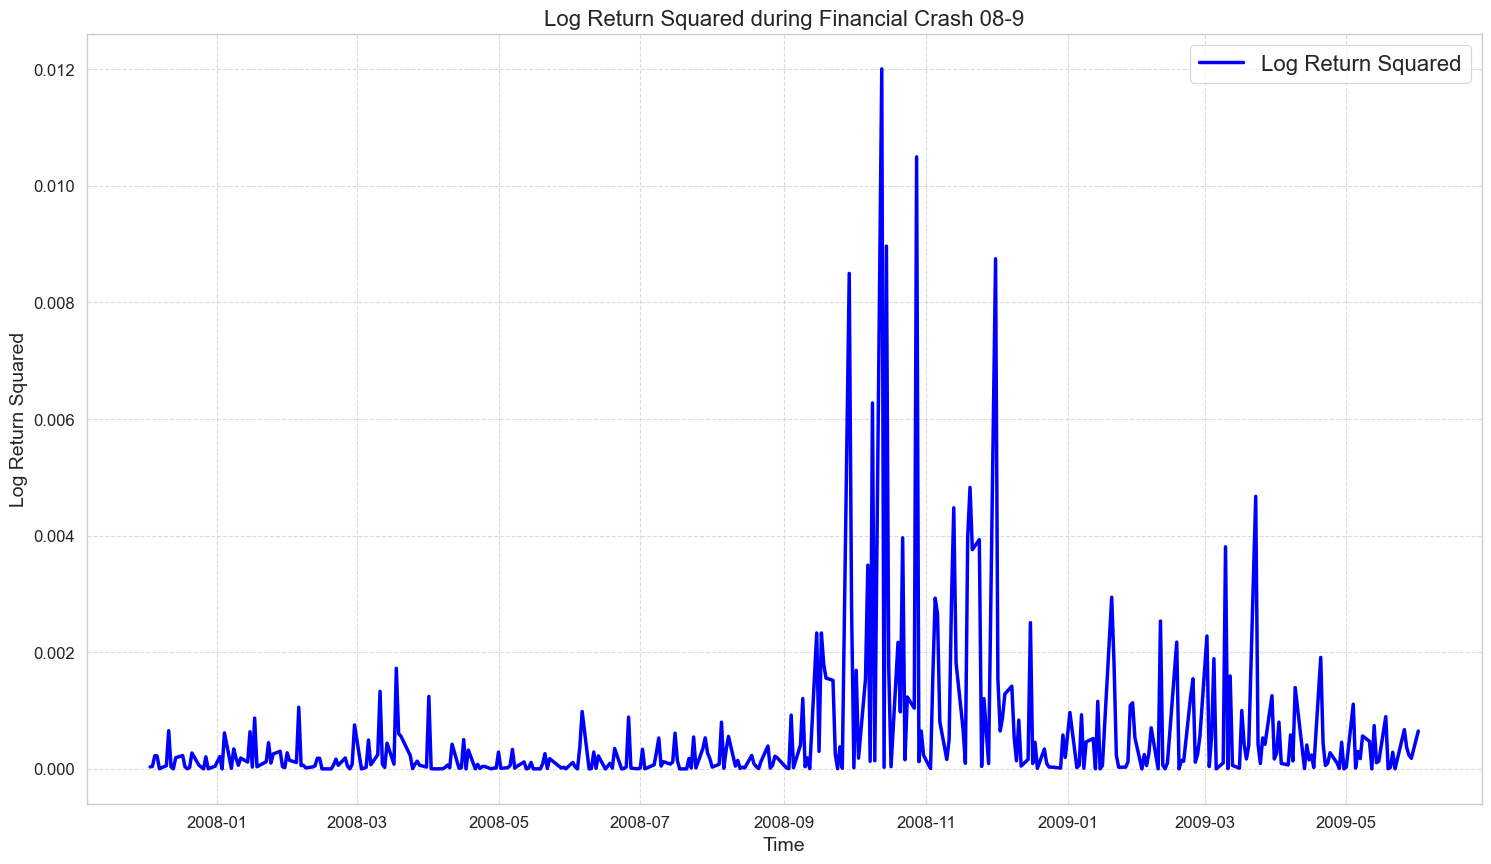

In [18]:
fig, ax = plt.subplots(figsize = (18,10))
plot_data(spx_df['Log Return'], 'Log Return', 'Log Returns from 2000-2025', ax)
plt.savefig('figures/log_return_a', dpi = 300)

fig, ax = plt.subplots(figsize = (18,10))
plot_data(crash_09_df['Log Return'], 'Log Return', 'Log Returns during Financial Crash 08-9', ax)
plt.savefig('figures/log_return_b', dpi = 300)

fig, ax = plt.subplots(figsize = (18,10))
plot_data(spx_df['Log Return Squared'], 'Log Return Squared','Log Returns from 2000-2025' ,ax)
plt.savefig('figures/log_return_squared_c', dpi = 300)

fig, ax = plt.subplots(figsize = (18,10))
plot_data(crash_09_df['Log Return Squared'], 'Log Return Squared', 'Log Return Squared during Financial Crash 08-9', ax)
plt.savefig('figures/log_return_squared_d', dpi = 300)


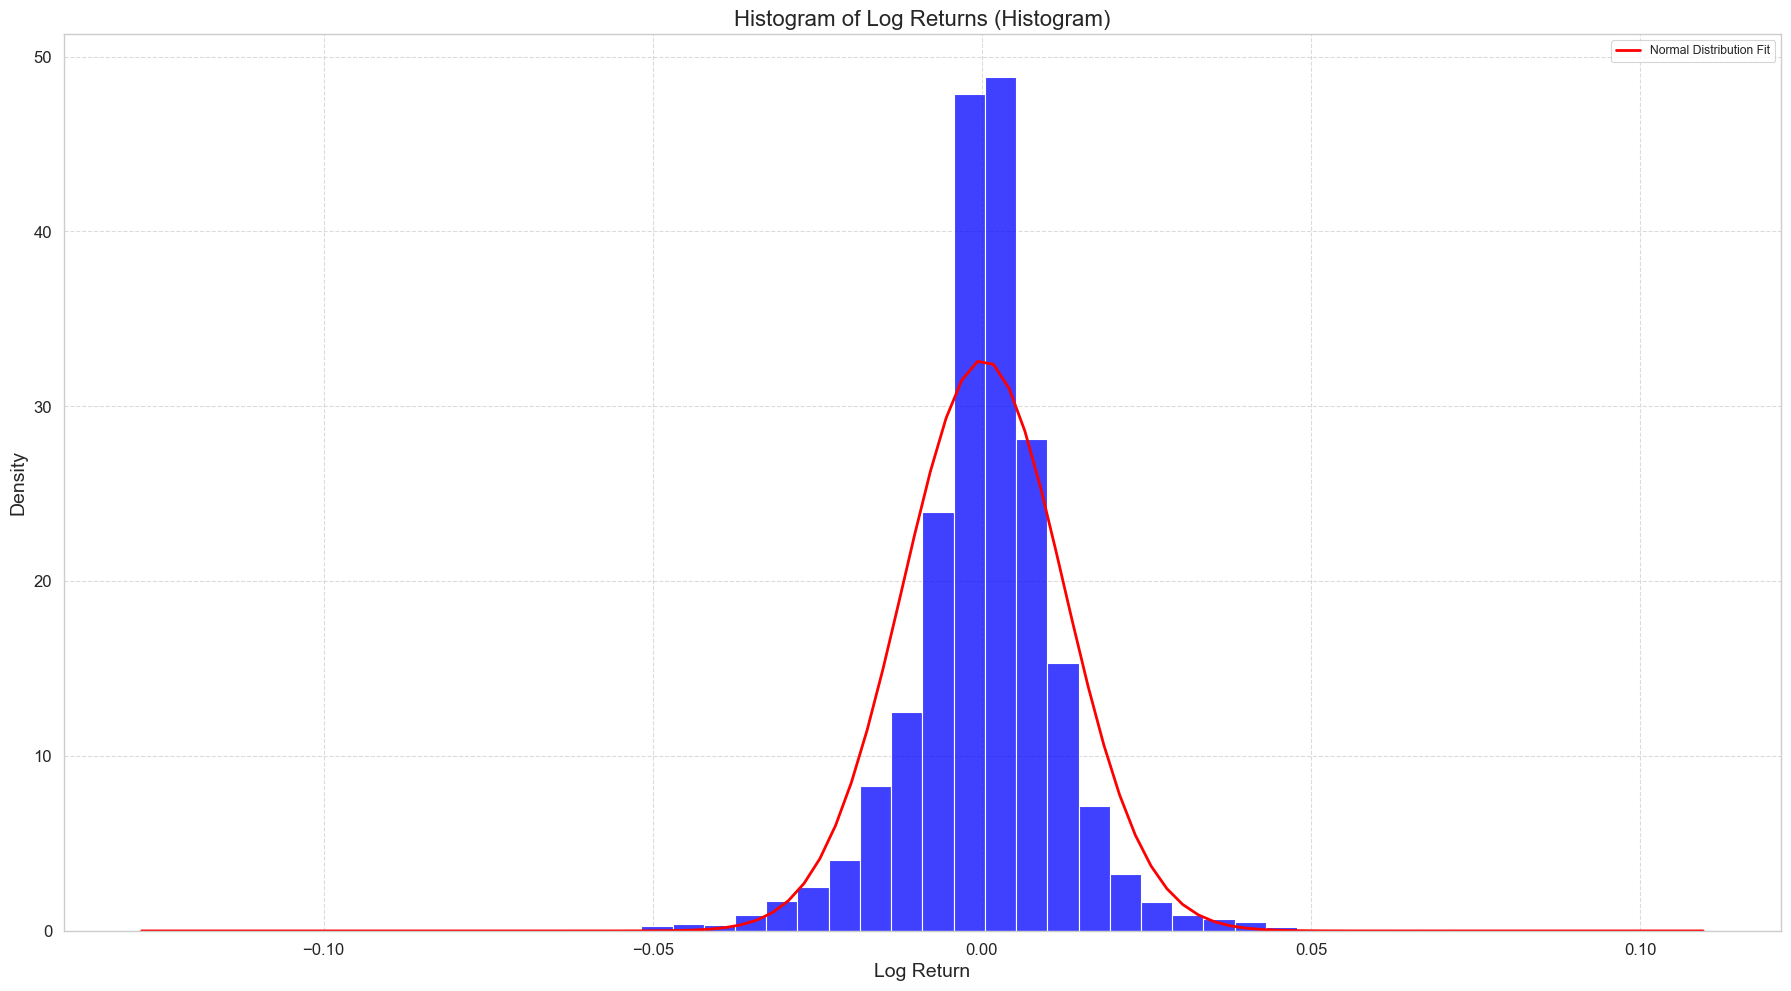

In [19]:
fig, ax = plt.subplots(figsize=(18, 10))

plot_data(spx_df['Log Return'], 'Log Return', 'Histogram of Log Returns', ax, hist=True)

# Plot overlay of normal distribution
mean = np.mean(spx_df['Log Return'])
std = np.std(spx_df['Log Return'])

xmin, xmax = np.min(spx_df['Log Return']), np.max(spx_df['Log Return'])
x = np.linspace(xmin, xmax, 100)

pdf = norm.pdf(x, mean, std)  # Compute the PDF for the normal distribution
sns.lineplot(x=x, y=pdf, ax=ax, color='red', lw=2, label='Normal Distribution Fit')

ax.legend(loc='best')

plt.tight_layout()
plt.savefig('figures/histogram_log_return.png', dpi = 300)
plt.show()

### 3b. Realised Volatility 

In [20]:
def rv_daily(series): 
    """
    Get daily RV wiithin a specific window interval; standard deviation over certain window
    """
    n = len(series)
    bar_r = np.mean(series) # Average log returns 
    return np.sqrt((1/n) * np.sum((series - bar_r)**2)) # Realised volatility 

In [21]:
windows = [7, 14, 21, 28]

In [22]:
# Create a copy of the dataframe with all realised volatility values 
rv_df = spx_df.copy() 

In [23]:
# Find realised volatility for different windows 
for i in windows:
    rv_df[f'Future RV-{i}'] = (
        rv_df['Log Return']
        .iloc[::-1]  # Reverse order to do forward rolling
        .rolling(i)  # Apply rolling window for each interval separately
        .apply(rv_daily, raw=True)
        .iloc[::-1]  # Reverse back to original order
    )

In [24]:
rv_df.tail(10)

Close    Returns  Log Return  Log Return Squared  \
Date                                                                 
2025-01-31  6040.529785 -30.640137   -0.005060        2.559959e-05   
2025-02-03  5994.569824 -45.959961   -0.007638        5.833432e-05   
2025-02-04  6037.879883  43.310059    0.007199        5.182427e-05   
2025-02-05  6061.479980  23.600098    0.003901        1.521822e-05   
2025-02-06  6083.569824  22.089844    0.003638        1.323267e-05   
2025-02-07  6025.990234 -57.579590   -0.009510        9.043717e-05   
2025-02-10  6066.439941  40.449707    0.006690        4.475760e-05   
2025-02-11  6068.500000   2.060059    0.000340        1.152773e-07   
2025-02-12  6051.970215 -16.529785   -0.002728        7.439710e-06   
2025-02-13  6115.069824  63.099609    0.010372        1.075849e-04   

            High Low Range  Future RV-7  Future RV-14  Future RV-21  \
Date                                                                  
2025-01-31        0.014810     0.006539           NaN           NaN   
2025-02-03        0.016441     0.006221           NaN           NaN   
2025-02-04        0.008578     0.005478           NaN           NaN   
2025-02-05        0.009246     0.006044           NaN           NaN   
2025-02-06        0.006133          NaN           NaN           NaN   
2025-02-07        0.013418          NaN           NaN           NaN   
2025-02-10        0.004710          NaN           NaN           NaN   
2025-02-11        0.005601          NaN           NaN           NaN   
2025-02-12        0.009945          NaN           NaN           NaN   
2025-02-13        0.010842          NaN           NaN           NaN   

            Future RV-28  
Date                      
2025-01-31           NaN  
2025-02-03           NaN  
2025-02-04           NaN  
2025-02-05           NaN  
2025-02-06           NaN  
2025-02-07           NaN  
2025-02-10           NaN  
2025-02-11           NaN  
2025-02-12           NaN  
2025-02-13           NaN

**Plot the different values of realised volatility**

In [25]:
crash_09_df_vol = rv_df.loc['2007-12-01':'2009-06-01'] 

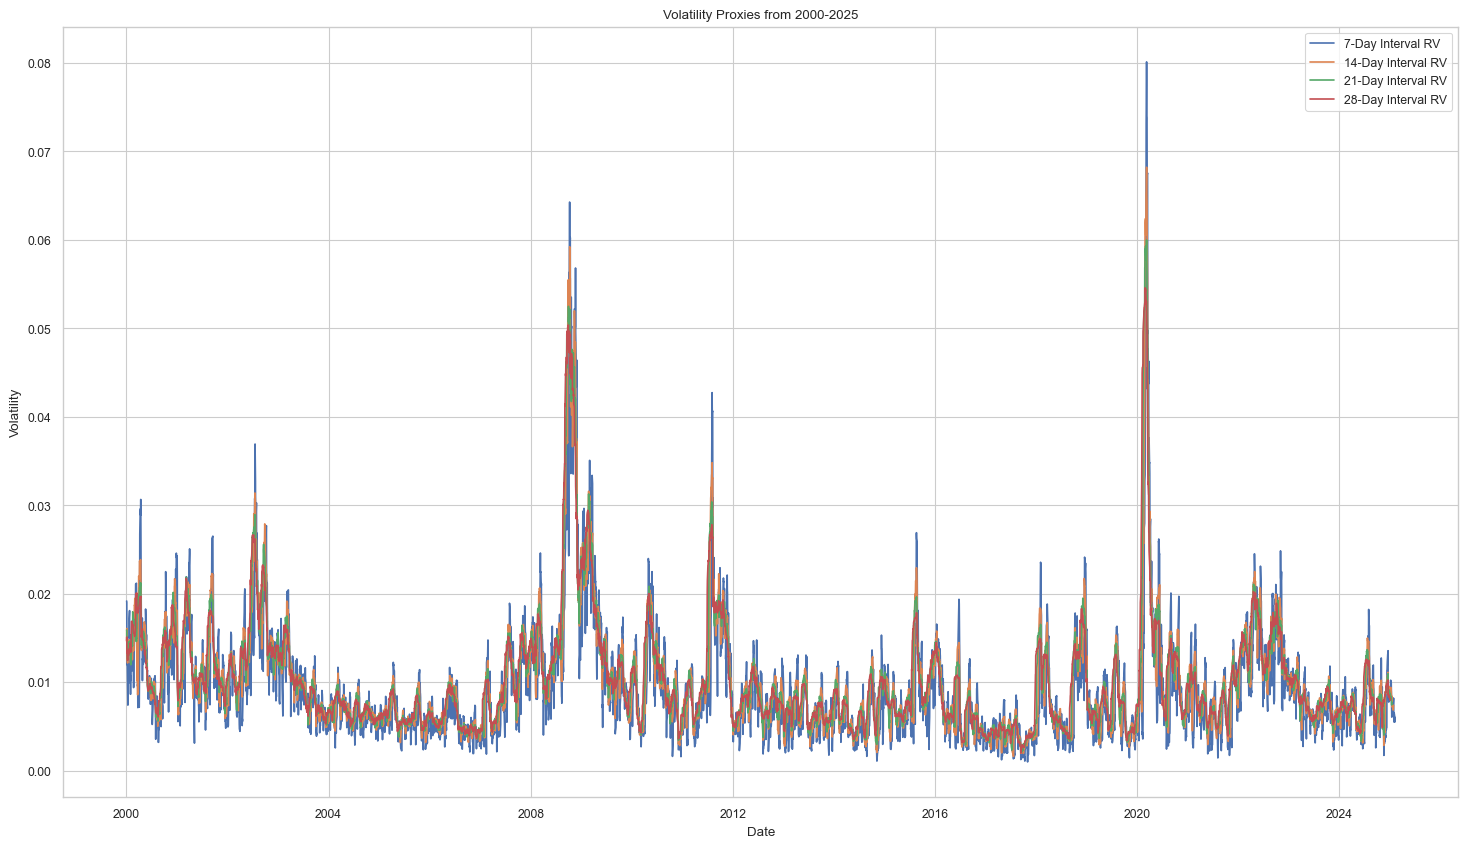

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols= 1, figsize = (18,10))

for i in windows: 
    sns.lineplot(data = rv_df, y = rv_df[f'Future RV-{i}'], x = 'Date', label = f'{i}-Day Interval RV', ax = ax)

ax.set_ylabel('Volatility')

plt.title('Volatility Proxies from 2000-2025')

plt.legend(loc = 'best')
plt.show()

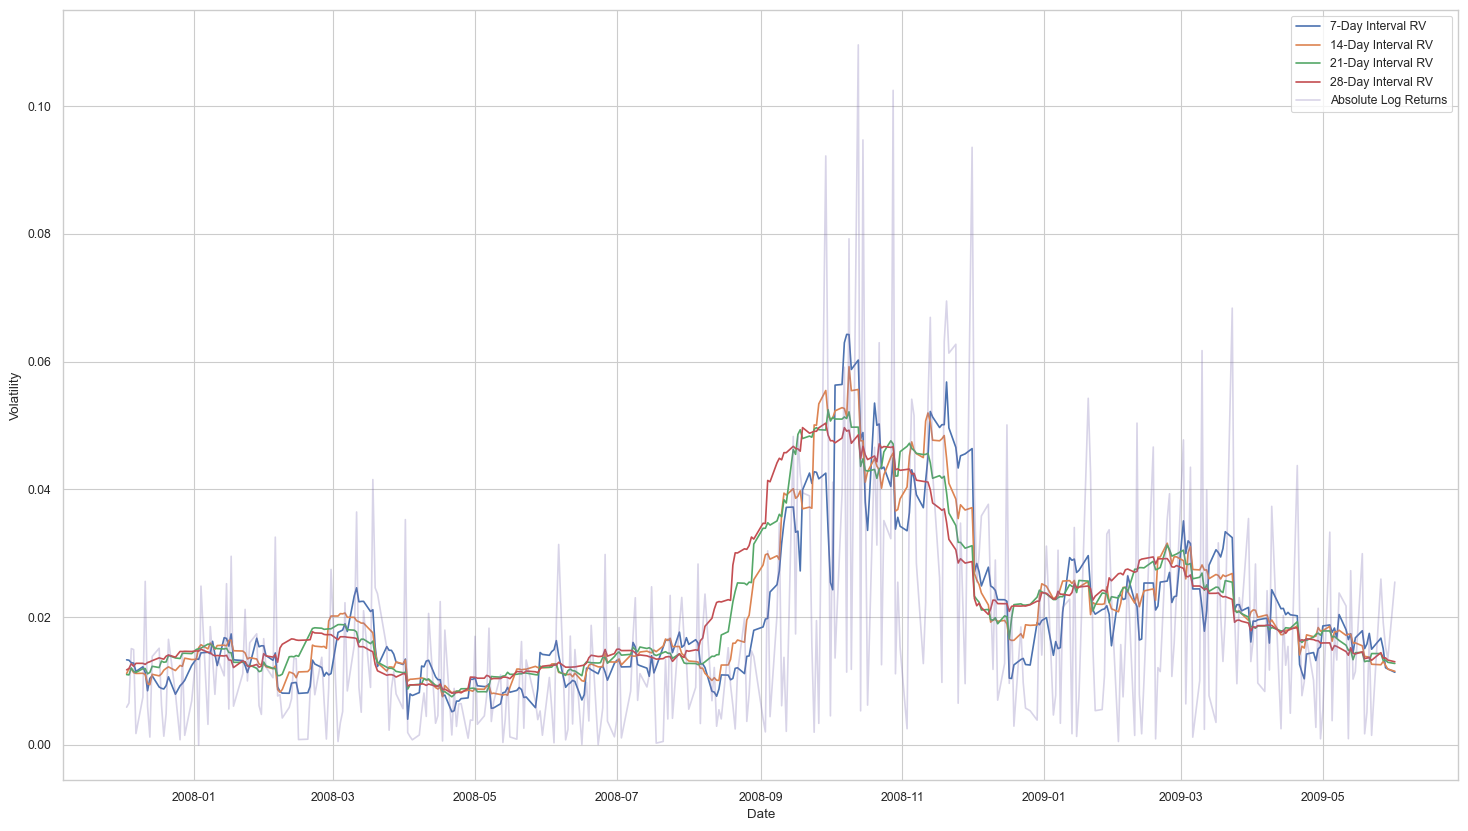

In [27]:
fig, ax = plt.subplots(figsize=(18, 10))

# Top plot: log returns + RVs
for i in windows:
    sns.lineplot(data=crash_09_df_vol, y=crash_09_df_vol[f'Future RV-{i}'], x='Date', label=f'{i}-Day Interval RV', ax=ax)
sns.lineplot(data=crash_09_df_vol, y=abs(crash_09_df_vol['Log Return']), x='Date', label='Absolute Log Returns', alpha=0.3, ax=ax)

ax.set_ylabel('Volatility')
ax.legend()
ax.grid(True)

plt.savefig('figures/vol_proxies')
plt.show()

**Choice of Proxy**
For my research I will use the 21-Day Realised Volatility (common practise). 

In [28]:
interval = 21 

### 3d. Descriptive Statistics 

In [29]:
def df_stats(df):
    stat_list = []
    
    for col in df.columns:
        series = df[col].dropna()
        
        stats = {}
        
        # Basic Stats 
        stats['Name'] = f"SPX {series.name}"
        stats['Mean'] = series.mean()
        stats['Standard Deviation'] = series.std()
        stats['Skewness'] = skew(series)
        stats['Kurtosis'] = kurtosis(series, fisher=False)

        #JB test for normality; H1 is that data is not normally distributed
        jb_stat, jb_p = jarque_bera(series)
        if jb_p < 0.01:
            stats['Jarque-Bera'] = f"{jb_stat:.2f} (***)"
        elif jb_p < 0.05:
            stats['Jarque-Bera'] = f"{jb_stat:.2f} (**)"
        else: 
            stats['Jarque-Bera'] = f"{jb_stat:.2f}"

        #ADF for stationarity; H1 is that data is stationary 
        adf_stat, adf_p, _, _, _, _ = adfuller(series)
        if adf_p < 0.01:
            stats['ADF'] = f"{adf_stat:.2f} (***)"
        elif adf_p < 0.05:
            stats['ADF'] = f"{adf_stat:.2f} (**)"
        else:
            stats['ADF'] = f"{adf_stat:.2f}"
            
        stat_list.append(stats)
    
    return pd.DataFrame(stat_list)

In [30]:
df_stat = df_stats(spx_df)

In [31]:
df_stat.to_csv('figures/desc_stats.csv', index=False)

## 1b. GARCH + Baseline Model

In [32]:
spx_df2 = rv_df.drop(columns = [f'Future RV-{i}' for i in [7,14,28]]+['Close'])

In [33]:
spx_df2

Returns  Log Return  Log Return Squared  High Low Range  \
Date                                                                    
1999-12-31        NaN         NaN                 NaN        0.009711   
2000-01-03 -14.030029   -0.009595        9.206392e-05        0.027186   
2000-01-04 -55.799927   -0.039099        1.528746e-03        0.040522   
2000-01-05   2.689941    0.001920        3.687698e-06        0.025505   
2000-01-06   1.339966    0.000955        9.124486e-07        0.014123   
...               ...         ...                 ...             ...   
2025-02-07 -57.579590   -0.009510        9.043717e-05        0.013418   
2025-02-10  40.449707    0.006690        4.475760e-05        0.004710   
2025-02-11   2.060059    0.000340        1.152773e-07        0.005601   
2025-02-12 -16.529785   -0.002728        7.439710e-06        0.009945   
2025-02-13  63.099609    0.010372        1.075849e-04        0.010842   

            Future RV-21  
Date                      
1999-12-31           NaN  
2000-01-03      0.015888  
2000-01-04      0.015800  
2000-01-05      0.013580  
2000-01-06      0.013580  
...                  ...  
2025-02-07           NaN  
2025-02-10           NaN  
2025-02-11           NaN  
2025-02-12           NaN  
2025-02-13           NaN  

[6319 rows x 5 columns]

In [34]:
spx_df2 = spx_df2.dropna(how = 'any')

In [35]:
spx_df2.shape

(6298, 5)

## 2a. Naive Model
The naive model will take the 21-Day Backward Looking volatility

In [36]:
# Find current volatility for time t 
naive_preds = spx_df2['Log Return'].rolling(window = 21).apply(rv_daily, raw = True).shift(1)

In [37]:
naive_preds[:22]

Date
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-18         NaN
2000-01-19         NaN
2000-01-20         NaN
2000-01-21         NaN
2000-01-24         NaN
2000-01-25         NaN
2000-01-26         NaN
2000-01-27         NaN
2000-01-28         NaN
2000-01-31         NaN
2000-02-01         NaN
2000-02-02    0.015888
Name: Log Return, dtype: float64

In [38]:
naive_preds.dropna(how = 'any')

Date
2000-02-02    0.015888
2000-02-03    0.015800
2000-02-04    0.013580
2000-02-07    0.013580
2000-02-08    0.013581
                ...   
2025-01-08    0.009520
2025-01-10    0.009504
2025-01-13    0.009930
2025-01-14    0.009952
2025-01-15    0.009735
Name: Log Return, Length: 6277, dtype: float64

## 2b. Preliminary GARCH/EGARCH Models

### 3a. Data Preprocessing

In [39]:
test_size = round(252*3.5)
val_size = round(252*3.5)
train_size = len(spx_df2) - (val_size + test_size) 

In [40]:
# Calculate percentages
train_pct = train_size / len(spx_df2) * 100
val_pct = val_size / len(spx_df2) * 100
test_pct = test_size / len(spx_df2) * 100

# Calculate index splits
split_time1 = len(spx_df2) - (test_size + val_size)
split_time2 = len(spx_df2) - test_size

# Get indexes
train_idx = spx_df2.index[:split_time1]
val_idx = spx_df2.index[split_time1:split_time2]
test_idx = spx_df2.index[split_time2:]

In [41]:
# Build structured dictionary
data_split_info = {
    'Set': ['Train', 'Validation', 'Test'],
    'Size': [train_size, val_size, test_size],
    'Percentage': [train_pct, val_pct, test_pct],
    'Start Date': [train_idx[0], val_idx[0], test_idx[0]],
    'End Date': [train_idx[-1], val_idx[-1], test_idx[-1]],
    'Duration (days)': [len(train_idx), len(val_idx), len(test_idx)]
}

# Convert to DataFrame
split_df = pd.DataFrame(data_split_info)

In [42]:
split_df

Set  Size  Percentage Start Date   End Date  Duration (days)
0       Train  4534   71.991108 2000-01-03 2018-01-09             4534
1  Validation   882   14.004446 2018-01-10 2021-07-13              882
2        Test   882   14.004446 2021-07-14 2025-01-15              882

In [43]:
split_df.to_excel("data_split_info.xlsx", index=False)

Get statistics on train, validation and test data

In [44]:
train_val_stat = df_stats(spx_df2.loc[np.hstack([train_idx,val_idx])])
train_val_stat

Name      Mean  Standard Deviation   Skewness  \
0             SPX Returns  0.535443           21.196693  -1.115946   
1          SPX Log Return  0.000201            0.012469  -0.397745   
2  SPX Log Return Squared  0.000155            0.000560  13.406360   
3      SPX High Low Range  0.013143            0.010199   3.062777   
4        SPX Future RV-21  0.010137            0.006843   3.099347   

     Kurtosis        Jarque-Bera           ADF  
0   31.338330    182348.21 (***)  -14.90 (***)  
1   13.993534     27416.38 (***)  -13.61 (***)  
2  262.926545  15408684.96 (***)   -7.67 (***)  
3   18.854671     65193.52 (***)   -5.99 (***)  
4   17.225570     54338.42 (***)   -6.27 (***)

In [45]:
test_stat = df_stats(spx_df2.loc[test_idx])
test_stat

Name      Mean  Standard Deviation  Skewness   Kurtosis  \
0             SPX Returns  1.792177           46.735632 -0.300536   4.317999   
1          SPX Log Return  0.000350            0.010658 -0.236678   4.857636   
2  SPX Log Return Squared  0.000114            0.000222  5.183255  44.990377   
3      SPX High Low Range  0.012035            0.006993  1.482165   6.068924   
4        SPX Future RV-21  0.009674            0.003921  0.882853   3.037904   

      Jarque-Bera           ADF  
0     77.12 (***)  -28.91 (***)  
1    135.05 (***)  -29.10 (***)  
2  68746.62 (***)   -4.45 (***)  
3    669.05 (***)   -4.38 (***)  
4    114.63 (***)         -1.85

In [46]:
train_val_stat.to_excel('figures/train_val_stat.xlsx', index = False)
test_stat.to_excel('figures/test_stat.xlsx', index = False)

Getting data for GARCH

In [47]:
# This will be used for intial model selection of GARCH (up to train index end)
lr_train = spx_df2['Log Return'][train_idx]

# Used when we train model and validate against data 
log_returns = spx_df2['Log Return'] 

In [48]:
# Basic train/val/test dataframes these will be used/modified later on for LSTM training/val/test
train_df = spx_df2.loc[train_idx] 
val_df = spx_df2.loc[val_idx]
test_df = spx_df2.loc[test_idx]

In [49]:
# Used to validate GARCH model on validation/test data 
RV_val = val_df['Future RV-21']
RV_test = test_df['Future RV-21']

### Visualising the train, validation and test split. 

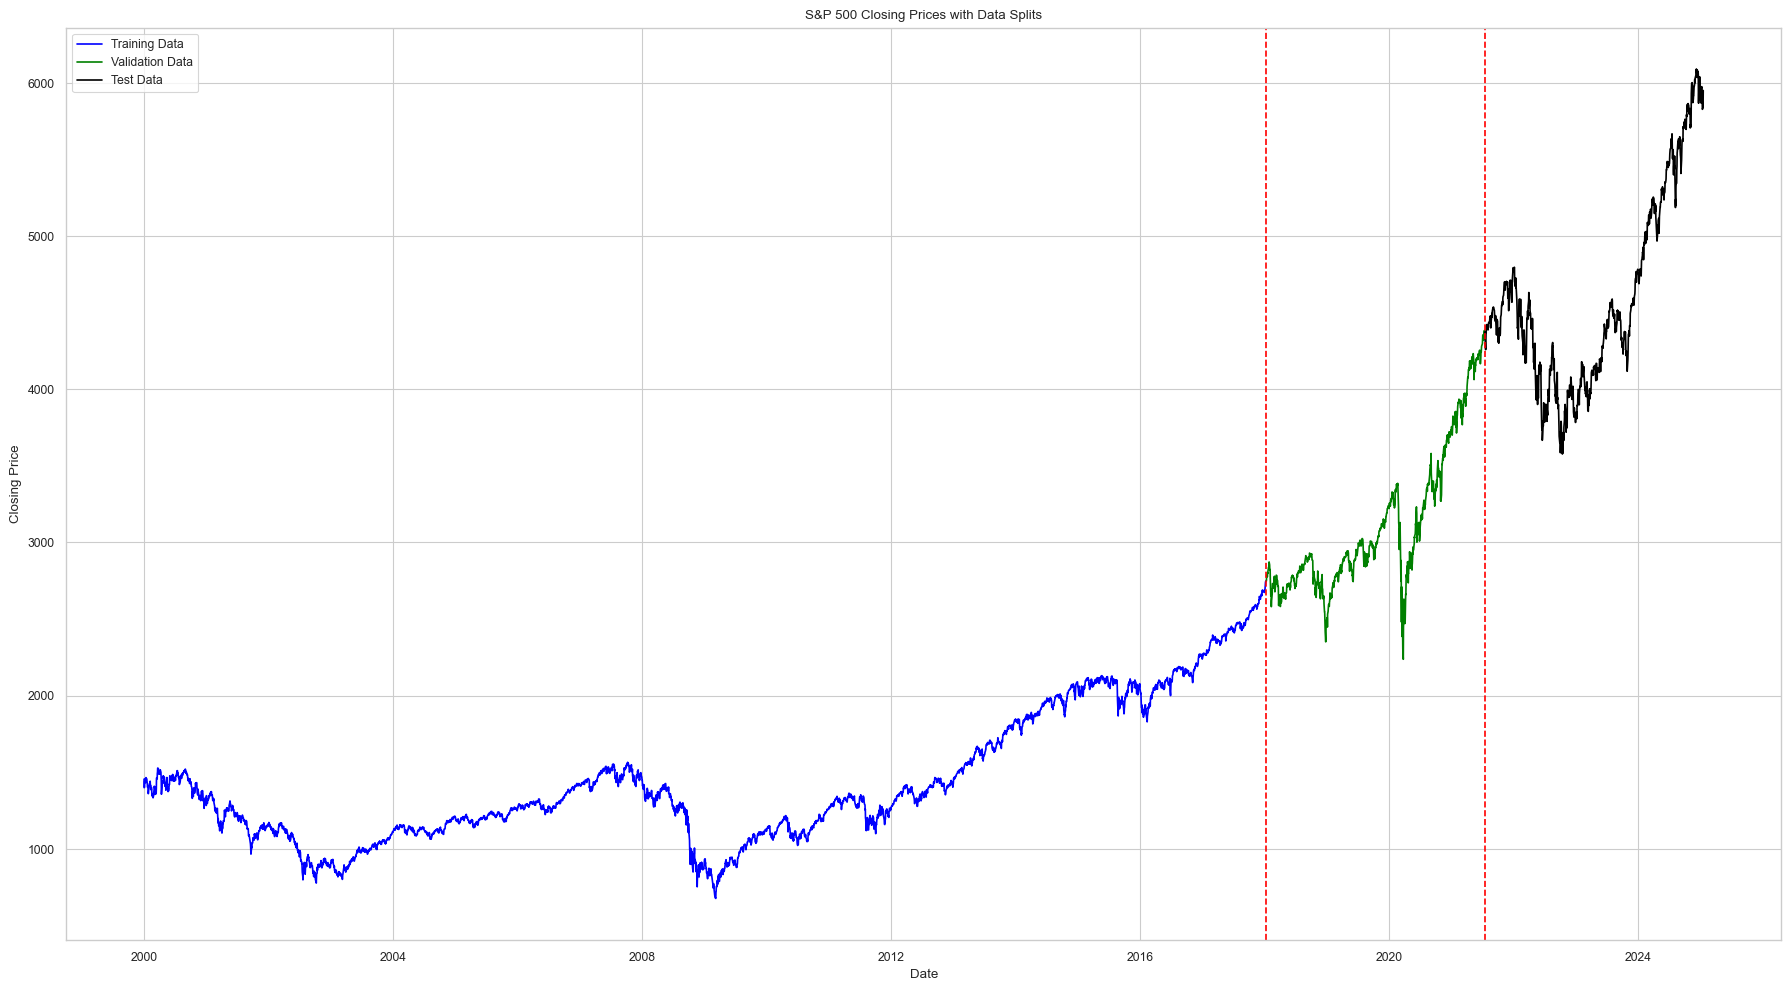

In [50]:
plt.figure(figsize=(18, 10))

# Plot the training data in blue
sns.lineplot(data=spx_df.loc[train_idx], x='Date', y='Close', color='blue', label='Training Data')

# Plot the validation data in green
sns.lineplot(data=spx_df.loc[val_idx], 
             x='Date', y='Close', color='green', label='Validation Data')

# Plot the test data in black
sns.lineplot(data=spx_df.loc[test_idx], x='Date', y='Close', color='black', label='Test Data')

# Add vertical lines marking the transitions between the sets
plt.axvline(x=train_idx[-1], color='red', linestyle='--')
plt.axvline(x=(val_idx[-1]), color='red', linestyle='--')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('S&P 500 Closing Prices with Data Splits')
plt.legend()

# Save plot
plt.savefig("figures/sp500_train_test_split.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

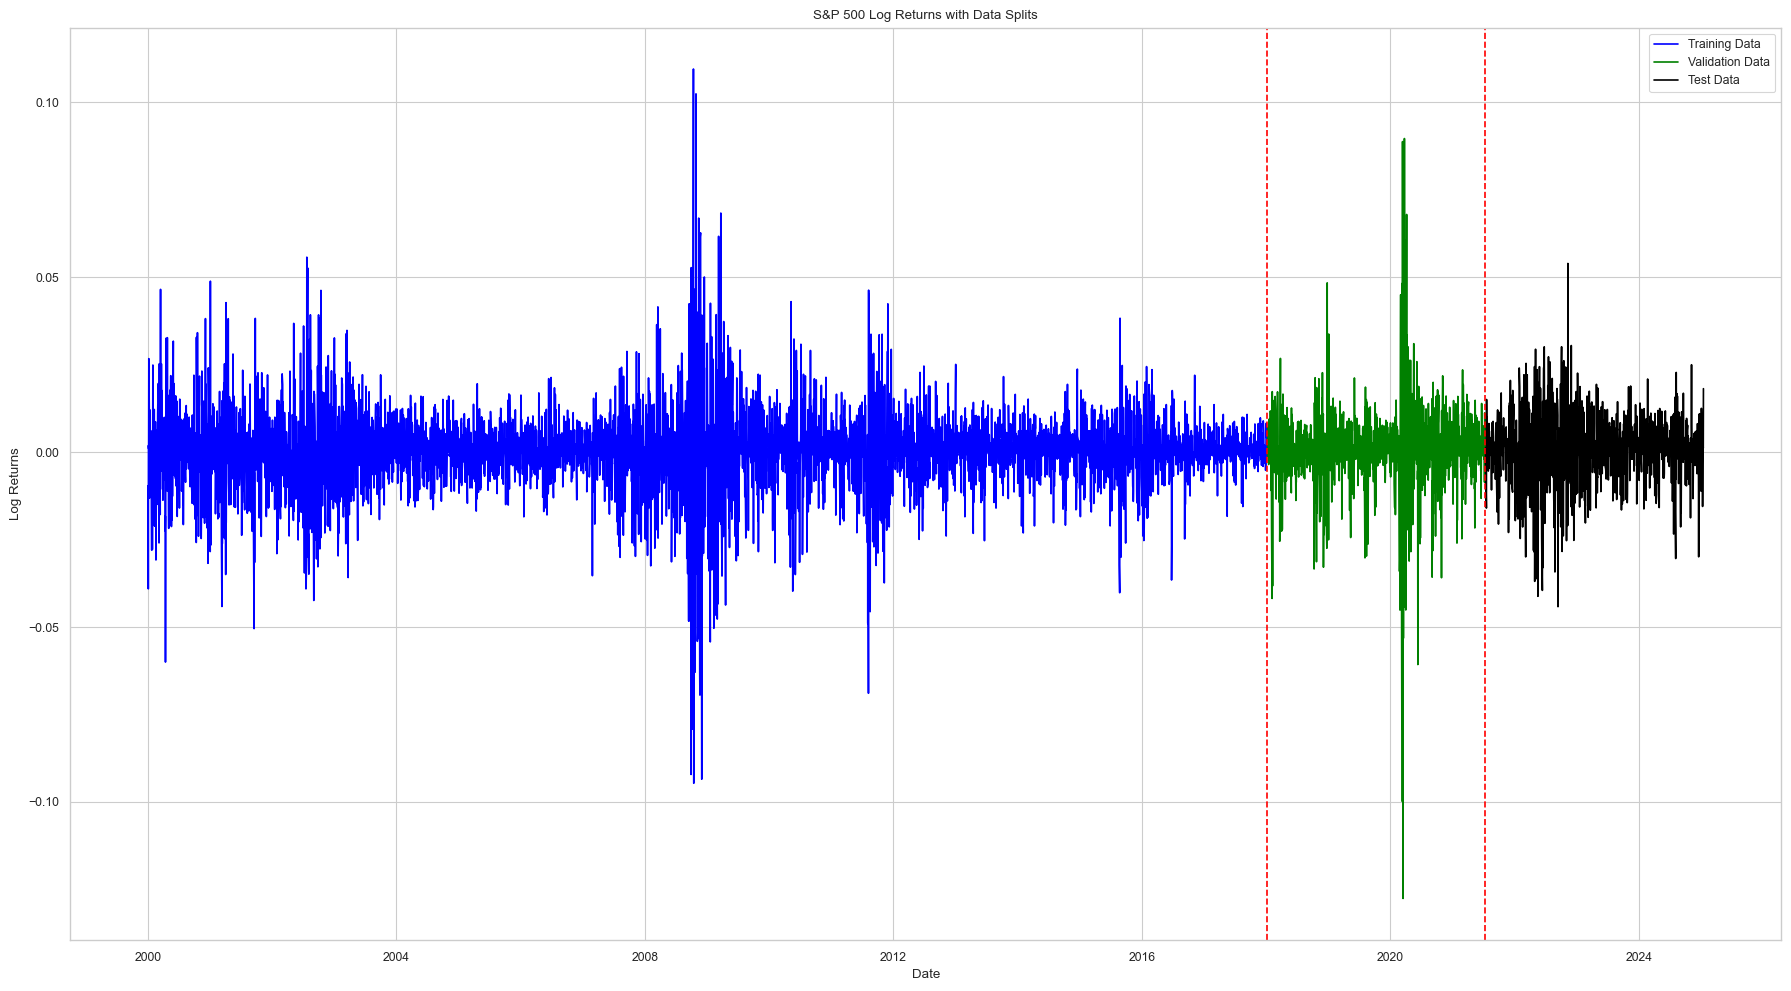

In [51]:
plt.figure(figsize=(18, 10))

# Plot the training data in blue
sns.lineplot(data=spx_df.loc[train_idx], x='Date', y='Log Return', color='blue', label='Training Data')

# Plot the validation data in green
sns.lineplot(data=spx_df.loc[val_idx], 
             x='Date', y='Log Return', color='green', label='Validation Data')

# Plot the test data in black
sns.lineplot(data=spx_df.loc[test_idx], x='Date', y='Log Return', color='black', label='Test Data')

# Add vertical lines marking the transitions between the sets
plt.axvline(x=train_idx[-1], color='red', linestyle='--')
plt.axvline(x=(val_idx[-1]), color='red', linestyle='--')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('S&P 500 Log Returns with Data Splits')
plt.legend()

# Save plot
plt.savefig("figures/sp500_train_test_split_log_return.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

**GARCH Fitting Process**: 
1. First we saw the distribution was leptokurtic -> volatility clusterring
2. Analysis of log returns and log retruns squared in ACF plot shows weak dependence in returns but strong dependence structure in squared returns 
3. As an additional analysis, fit an AR(1) model and had a look at the squared residuals; see significant autocorrelation, it's clear we need an ARCH/GARCH model to capture volatility clusters

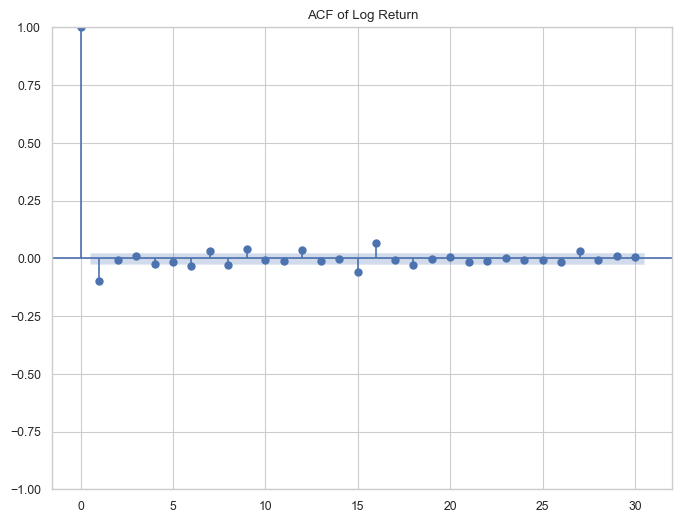

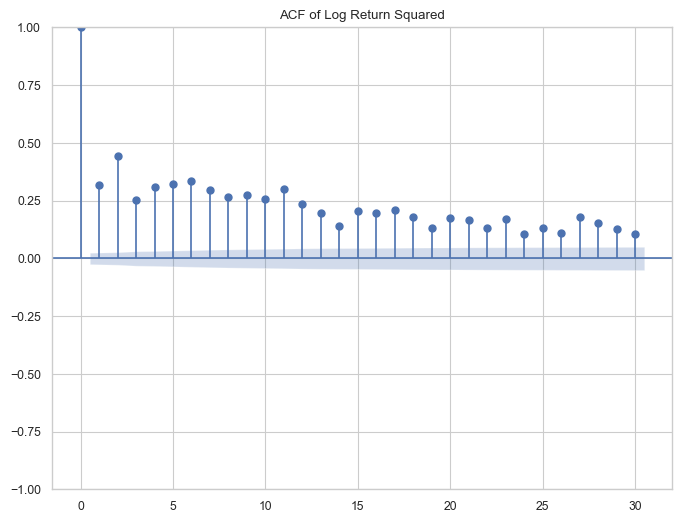

In [52]:
plt.figure(figsize=(8,6))
plot_acf(x= spx_df2["Log Return"], lags = 30, ax = plt.gca(), alpha = 0.05)
plt.title('ACF of Log Return')
plt.savefig('figures/acf_log_return_squared', dpi = 300)

plt.figure(figsize=(8,6))
plot_acf(x= spx_df2["Log Return Squared"], lags = 30, ax = plt.gca(), alpha = 0.05)
plt.title('ACF of Log Return Squared')
plt.savefig('figures/acf_log_return_sq.png', dpi = 300)
plt.show()

**ARIMA Model**

In [53]:
model = ARIMA(spx_df2['Log Return'], order=(1, 0, 0))
fitted_model = model.fit()
print(fitted_model.summary())
residuals = fitted_model.resid

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                 6298
Model:                 ARIMA(1, 0, 0)   Log Likelihood               18830.336
Date:                Sun, 04 May 2025   AIC                         -37654.673
Time:                        22:46:11   BIC                         -37634.429
Sample:                             0   HQIC                        -37647.660
                               - 6298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.548      0.122   -5.91e-05       0.001
ar.L1         -0.0992      0.006    -15.983      0.000      -0.111      -0.087
sigma2         0.0001   1.12e-06    132.219      0.0

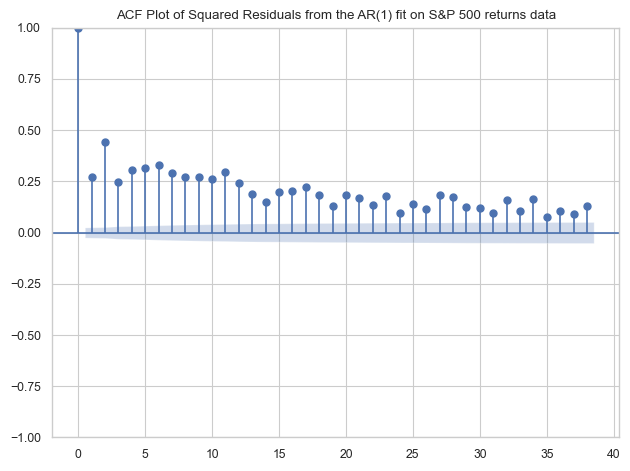

In [54]:
plot_acf(np.square(residuals), title='ACF Plot of Squared Residuals from the AR(1) fit on S&P 500 returns data')
plt.tight_layout()
plt.savefig('figures/ACF_plot_squared_resid_AR1.png', dpi = 300)
plt.show()

In [55]:
# No Autocorrelation present in squared residuals 
lb_test = acorr_ljungbox((residuals), lags=10, return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
1    0.020317   0.886655
2    1.902809   0.386198
3    2.130199   0.545828
4    6.055316   0.195055
5    8.505212   0.130503
6   15.553301   0.016363
7   19.825853   0.005958
8   22.855597   0.003555
9   31.870676   0.000210
10  31.903134   0.000416


In [56]:
# Autocorrelation present in squared residuals 
lb_test = acorr_ljungbox(np.square(residuals), lags=10, return_df=True)
print(lb_test)

        lb_stat      lb_pvalue
1    468.082417  8.376268e-104
2   1701.289403   0.000000e+00
3   2080.958932   0.000000e+00
4   2676.442462   0.000000e+00
5   3298.125667   0.000000e+00
6   3978.913572   0.000000e+00
7   4509.576365   0.000000e+00
8   4968.225734   0.000000e+00
9   5429.430795   0.000000e+00
10  5859.415985   0.000000e+00


## 2c. GARCH Model Selection

In [57]:
gm_1 = arch_model(
    lr_train, # Train on train log returns
    vol = 'Garch', 
    p = 1,
    q = 1,
    mean = 'Zero',
    dist = 'Normal', 
    rescale = True # Rescale to help with parameter estimation
)
result_1 = gm_1.fit(disp = 'off')
scale_gm1 = result_1.scale
result_1

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6211.46
Distribution:                  Normal   AIC:                           12428.9
Method:            Maximum Likelihood   BIC:                           12448.2
                                        No. Observations:                 4534
Date:                Sun, May 04 2025   Df Residuals:                     4534
Time:                        22:46:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0151  4.333e-03      3.493  4.781e-04 [6.

In [58]:
gm_2 = arch_model(
    lr_train, # Train on train log returns
    vol = 'Garch', 
    p = 1,
    q = 1,
    mean = 'Constant',
    dist = 'Normal', 
    rescale = True # Rescale to help with parameter estimation
)
result_2 = gm_2.fit(disp = 'off')
scale_gm2 = result_2.scale
result_2

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6201.70
Distribution:                  Normal   AIC:                           12411.4
Method:            Maximum Likelihood   BIC:                           12437.1
                                        No. Observations:                 4534
Date:                Sun, May 04 2025   Df Residuals:                     4533
Time:                        22:46:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0520  1.187e-02      4.377  1.206e-05 [2.

## 2d. Backtesting/Validation

In [59]:
T = [1]

### 3a. Rolling Window Forecasts 

In [60]:
def garch_forcast_roll(data, time_horizons, window_size, backtest_idx, order, mean_eq, vol_model = 'GARCH' ,res_dist = 'Normal'): 
    '''
    Input: data (ie. log returns), time horizon (list of forecasting horizons), window size, GARCH model parameter 
    (order, mean_eq, dist (default Normal)), backtest_idx = validation/test index. 
    '''
    T = time_horizons
    set_seed_all() # Ensure reproducibility

    gm_forecast_roll = pd.DataFrame(columns = [f'Vol-{t}' for t in T])
    idx = data.index # Get the index of log returns 
    
    # Define the integer location of the first datapoint used to train GARCH
    first = idx.get_loc(backtest_idx[0]) - window_size 
    
    end_idx = backtest_idx[0]
    start_idx = idx[first]
    
    print(f'Window size:{window_size}\n')
    print(f'First window, start:{start_idx}\t end:{end_idx}\n')
    
    # If you wanted to build longer forecasts you could
    for t in T: 
        rolling_forecast = []
        for i in range(len(backtest_idx)): 
            end_idx = backtest_idx[i] # End of the rolling fixed window
            start_idx = idx[first + i] # Start of rolling fixed window
            train = data[start_idx: end_idx]
                        
            model = arch_model(train,
                               p = order[0],
                               q = order[1],
                               mean = mean_eq, 
                               vol = vol_model,
                               rescale = True, 
                               dist = res_dist
                              )
         

            model_fit = model.fit(disp = 'off')
            
            # Forecast the vol (+rescaling)
            if t == 1: # One day ahead forecast
                cond_vol_pred = np.sqrt((model_fit.forecast(horizon = t, reindex = False)).variance.iloc[-1,0]) / model_fit.scale
                rolling_forecast.append(cond_vol_pred)
            
            else: # n days ahead forecasts 
                temp = np.sqrt((model_fit.forecast(horizon = t, reindex = False)).variance.values) / model_fit.scale
            
        gm_forecast_roll[f'Vol-{t}'] = rolling_forecast
        
    gm_forecast_roll.index = backtest_idx #Reindex with datetime index
    print('Fit sucessful')
    return gm_forecast_roll

Now we will generate our rolling window forecasts  

In [61]:
fixed_window_size = 252

In [62]:
# GARCH, Normal Dist, Zero Mean
gm1_forecast_roll = garch_forcast_roll(log_returns,T, fixed_window_size, val_idx, (1,1), 'Zero')

Window size:252

First window, start:2017-01-10 00:00:00	 end:2018-01-10 00:00:00

Fit sucessful


In [63]:
# GARCH, Normal Dist Constant Mean
gm2_forecast_roll = garch_forcast_roll(log_returns,T, fixed_window_size, val_idx, (1,1), 'Constant')

Window size:252

First window, start:2017-01-10 00:00:00	 end:2018-01-10 00:00:00

Fit sucessful


### 3b. Expanding Window Forecasts 

In [64]:
def garch_exp_forecast(data,time_horizons, backtest_idx, order, mean_eq, vol_model='GARCH' ,res_dist = 'Normal'): 
    '''
    Input: data (ie. log returns), time horizon (list of forecasting horizons), GARCH model parameter 
    (order, mean_eq, dist (default Normal)), backtest_idx = validation index. 
    '''
    
    set_seed_all()
    
    T = time_horizons
    
    gm_forecast_exp = pd.DataFrame(columns=[f'Vol-{t}' for t in T])
    
    print('Starting model fit...')
    
    for t in T: 
        expand_forecast = []
        
        for i in range(len(backtest_idx)): 
            idx = backtest_idx[i]
            train = data[:idx]
                        
            model = arch_model(train, 
                               p =order[0],
                               q=order[1],
                               vol = vol_model,
                               mean = mean_eq,
                               rescale = True,
                               dist = res_dist
                              )
            model_fit = model.fit(disp = 'off')
            if t == 1: # One day ahead forecast
                cond_vol_pred = np.sqrt((model_fit.forecast(horizon = t, reindex = False)).variance.iloc[-1,0]) / model_fit.scale
                expand_forecast.append(cond_vol_pred)
            else: # t days ahead forecasts
                temp = np.sqrt((model_fit.forecast(horizon = t, reindex = False)).variance.values) / model_fit.scale 
                cond_vol_pred = np.average(temp)
                expand_forecast.append(cond_vol_pred)
        
        gm_forecast_exp[f'Vol-{t}'] = expand_forecast # Append list to dataframe
    
    gm_forecast_exp.index = backtest_idx # Reindexing back to date
    return gm_forecast_exp 

In [65]:
gm1_forecast_exp = garch_exp_forecast(log_returns,T, val_idx, (1,1), 'Zero')

Starting model fit...


In [66]:
gm2_forecast_exp = garch_exp_forecast(log_returns,T, val_idx, (1,1), 'Constant')

Starting model fit...


## 2e. Plotting results on validation data 

In [67]:
def hmae(y_true, y_pred):
    return np.mean(np.abs(1-(y_pred/y_true)))

In [68]:
def hmse(y_true, y_pred): 
    return np.mean((1-(y_pred/y_true))**2)

In [69]:
perf_df = pd.DataFrame(columns = ['Model Name', 'MAE', 'HMAE', 'MSE', 'HMSE'])

In [70]:
def log_perf(y_true, y_pred, model_name, perf_df, inplace = True, name = 'Validation'): 
    new_row = [model_name, 
               mean_absolute_error(y_true, y_pred), 
               hmae(y_true, y_pred),
               mean_squared_error(y_true, y_pred),
               hmse(y_true, y_pred)]
    if inplace: 
        perf_df.loc[len(perf_df)] = new_row
        perf_df.to_excel(f'figures/{name}_results.xlsx', )
        return perf_df
    else: 
        copy_df = perf_df.copy()
        copy_df.loc[len(copy_df)] = new_row 
        return copy_df

In [71]:
log_perf(RV_val,naive_preds[val_idx], 'Benchmark Model', perf_df)

Model Name       MAE      HMAE       MSE      HMSE
0  Benchmark Model  0.005401  0.479794  0.000086  0.391833

In [72]:
log_perf(RV_val,gm1_forecast_roll['Vol-1'], 'GARCH(1,1) Zero Mean Rolling Window', perf_df)

Model Name       MAE      HMAE       MSE      HMSE
0                      Benchmark Model  0.005401  0.479794  0.000086  0.391833
1  GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060  0.275677

In [73]:
log_perf(RV_val,gm2_forecast_roll['Vol-1'], 'GARCH(1,1) Constant Mean Rolling Window', perf_df)

Model Name       MAE      HMAE       MSE  \
0                          Benchmark Model  0.005401  0.479794  0.000086   
1      GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2  GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802

In [74]:
log_perf(RV_val, gm1_forecast_exp['Vol-1'], 'GARCH(1,1) Zero Mean Expanding Window', perf_df)

Model Name       MAE      HMAE       MSE  \
0                          Benchmark Model  0.005401  0.479794  0.000086   
1      GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2  GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3    GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949

In [75]:
log_perf(RV_val,gm2_forecast_exp['Vol-1'], 'GARCH(1,1) Constant Mean Expanding Window', perf_df)

Model Name       MAE      HMAE       MSE  \
0                            Benchmark Model  0.005401  0.479794  0.000086   
1        GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2    GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3      GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4  GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284

We see that the rolling window outperforms the expanding window.

**Plotting the predictions**

In [76]:
def vis_pred(y_true, y_pred, model_name, ax):
    sns.lineplot(data=y_true, ax=ax, lw=2, label='Actual Volatility', color='blue')

    sns.lineplot(data=y_pred, ax=ax, lw=2, label='Forecasted Volatility', color='orange')

    ax.set_ylabel('Realised Volatility', fontsize=14)
    ax.set_xlabel('Time', fontsize=14)  # Customize if necessary
    ax.set_title(f'{model_name}', fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.legend(loc='best', frameon=True, fontsize=12)

    ax.grid(True, linestyle='--', alpha=0.7)

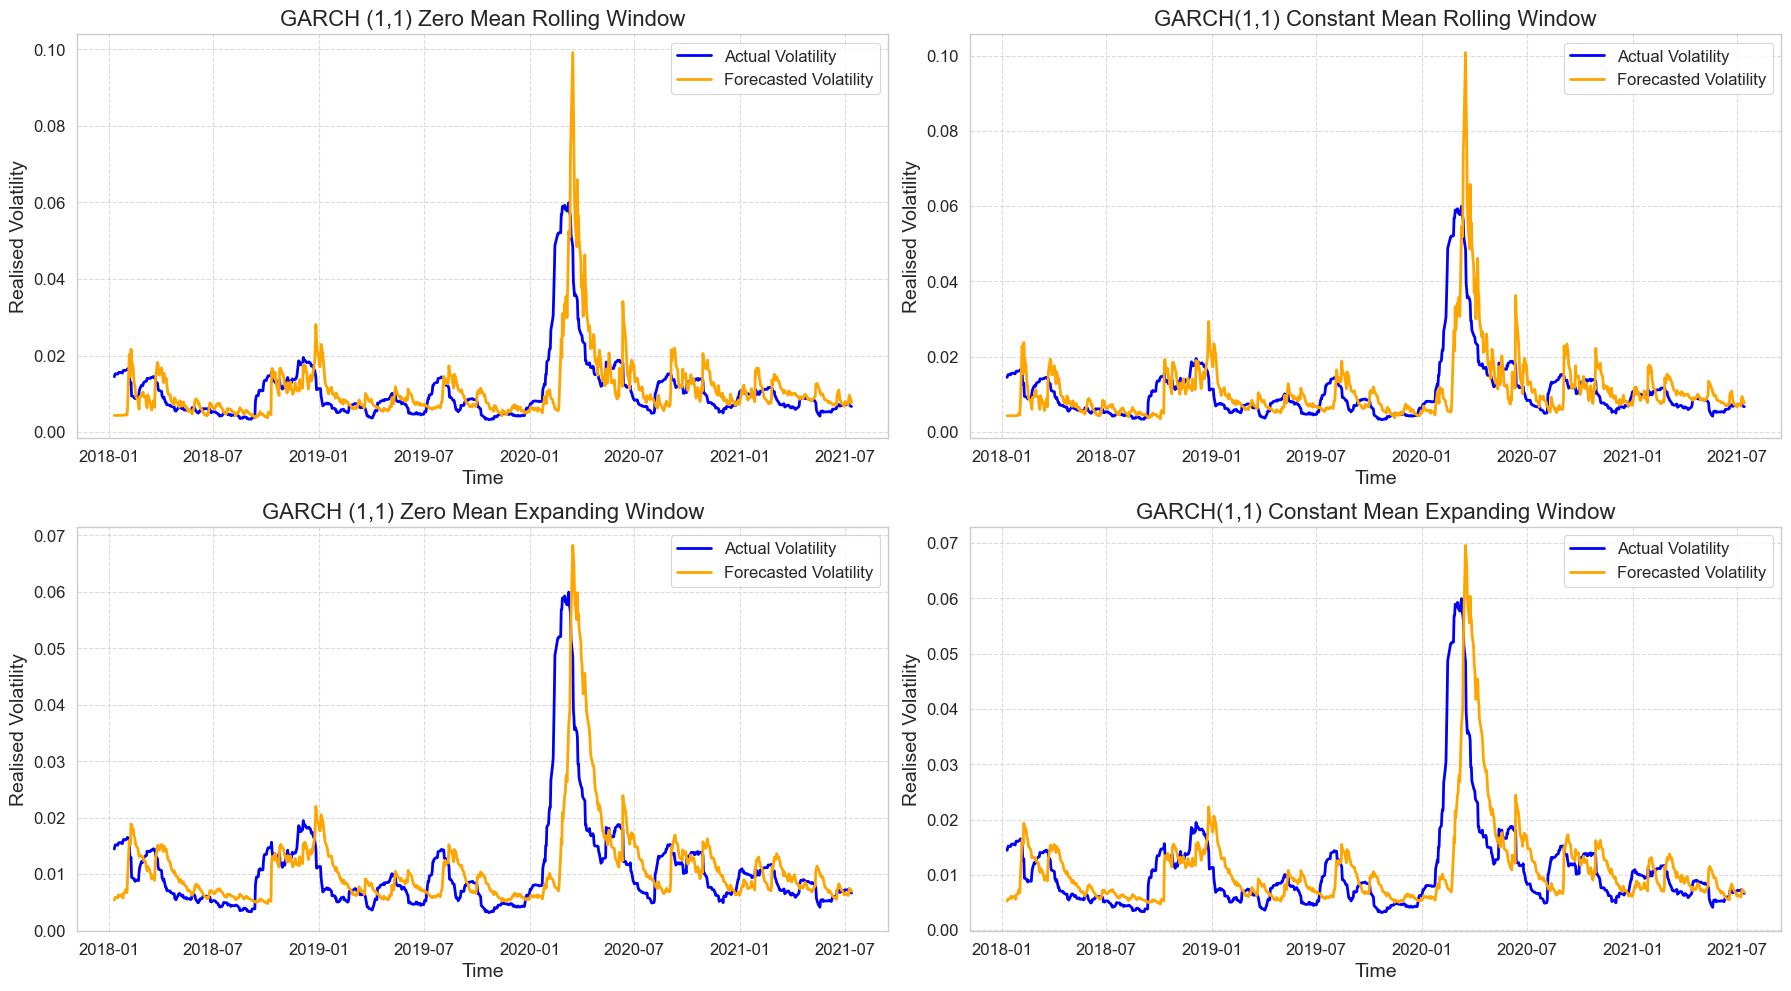

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

vis_pred(RV_val, gm1_forecast_roll['Vol-1'], 'GARCH (1,1) Zero Mean Rolling Window', axes[0,0])
vis_pred(RV_val, gm2_forecast_roll['Vol-1'], 'GARCH(1,1) Constant Mean Rolling Window', axes[0,1])

vis_pred(RV_val, gm1_forecast_exp['Vol-1'], 'GARCH (1,1) Zero Mean Expanding Window', axes[1,0])
vis_pred(RV_val, gm2_forecast_exp['Vol-1'], 'GARCH(1,1) Constant Mean Expanding Window', axes[1,1])

plt.tight_layout()
plt.show()

## 2d. Performance on Test Data
We need to get the performance of the naive model and our best performing GARCH model on the test set

In [78]:
# Create a new dataframe with the test results of the models 
perf_test_df = pd.DataFrame(columns = ['Model Name', 'Test MAE', 'Test HMAE', 'Test MSE', 'Test HMSE'])

In [79]:
log_perf(RV_test, naive_preds[test_idx], 'Benchmark Model', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0  Benchmark Model  0.002447   0.273101   0.00001   0.128265

In [80]:
# Get best GARCH model prediciton on test data 
gm_best_forecast_test = garch_forcast_roll(log_returns, T, fixed_window_size ,test_idx, (1,1), 'Constant' ,res_dist = 'Normal') 

Window size:252

First window, start:2020-07-14 00:00:00	 end:2021-07-14 00:00:00

Fit sucessful


In [81]:
# Get best GARCH model prediciton on test data (expanding)
gm_best_forecast_test_exp = garch_exp_forecast(log_returns, T ,test_idx, (1,1), 'Constant' ,res_dist = 'Normal') 

Starting model fit...


In [82]:
log_perf(RV_test, gm_best_forecast_test['Vol-1'], 'GARCH(1,1) Rolling', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0     Benchmark Model  0.002447   0.273101  0.000010   0.128265
1  GARCH(1,1) Rolling  0.002388   0.269345  0.000009   0.119719

In [83]:
log_perf(RV_test, gm_best_forecast_test_exp['Vol-1'], 'GARCH(1,1) Expanding', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0       Benchmark Model  0.002447   0.273101  0.000010   0.128265
1    GARCH(1,1) Rolling  0.002388   0.269345  0.000009   0.119719
2  GARCH(1,1) Expanding  0.002258   0.264538  0.000008   0.125679

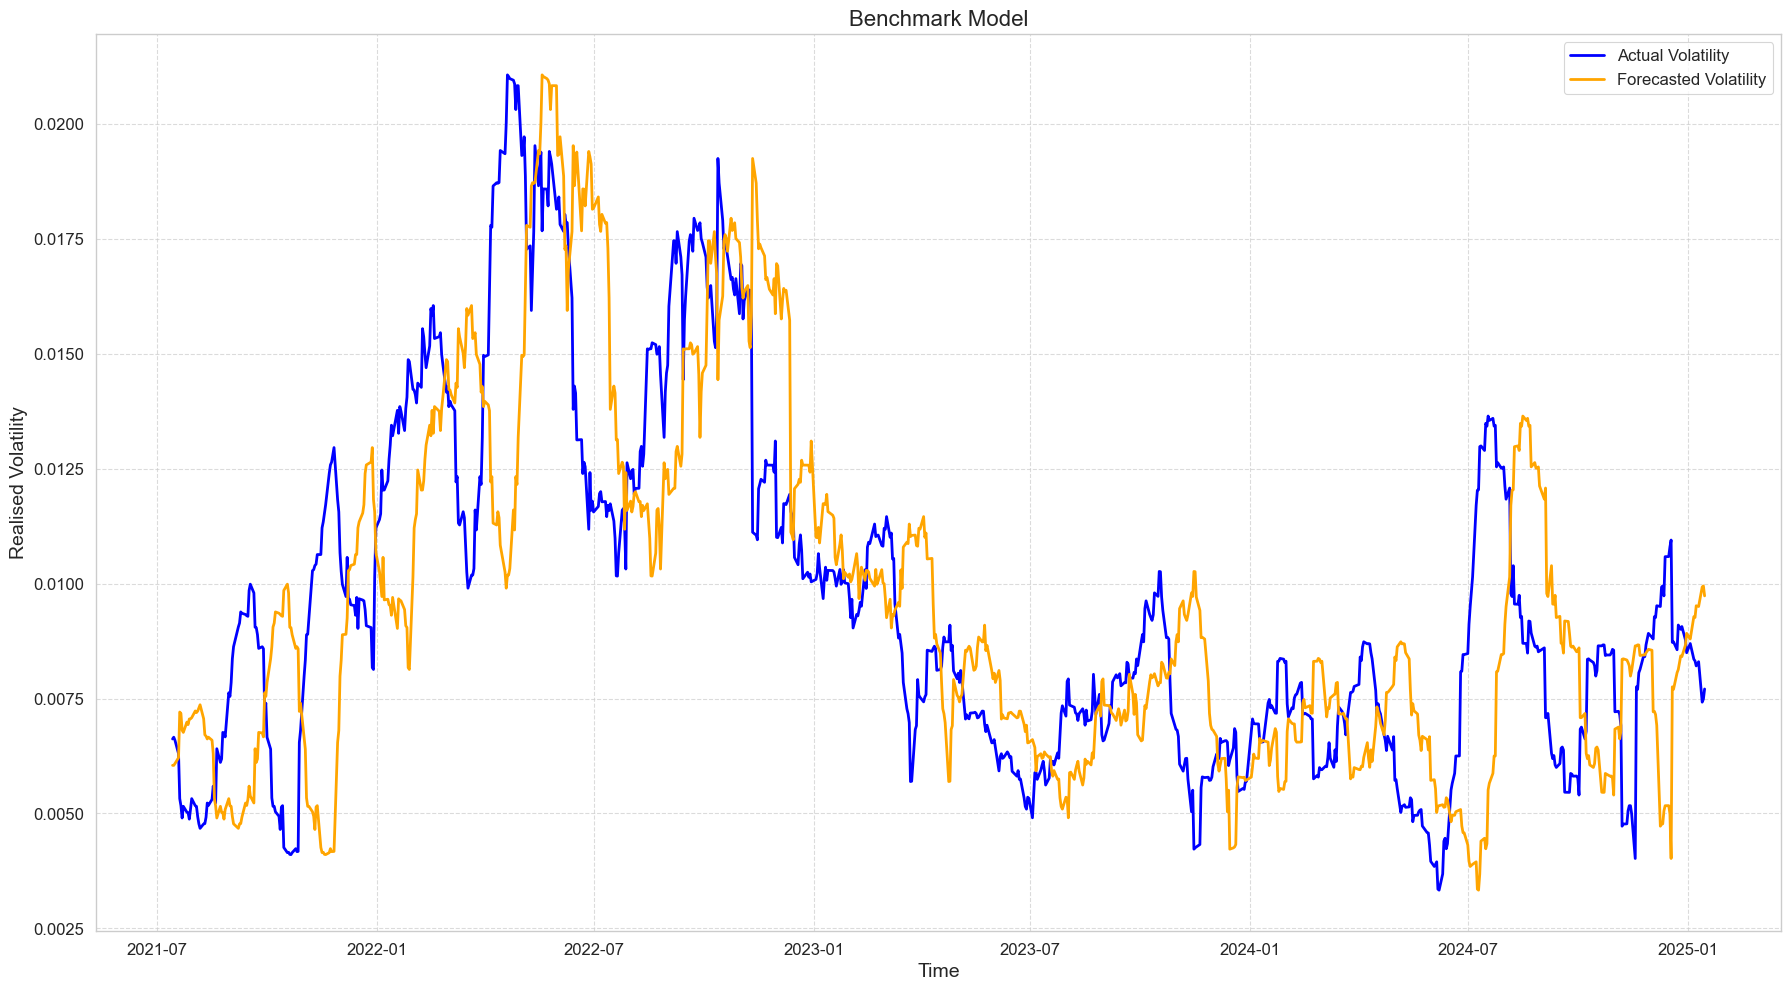

In [84]:
fig, ax = plt.subplots(figsize=(18, 10))

vis_pred(RV_test, naive_preds[test_idx], 'Benchmark Model', ax = ax)

plt.tight_layout()
plt.savefig('figures/naive_model_plot_test_data.png', dpi = 300)
plt.show()

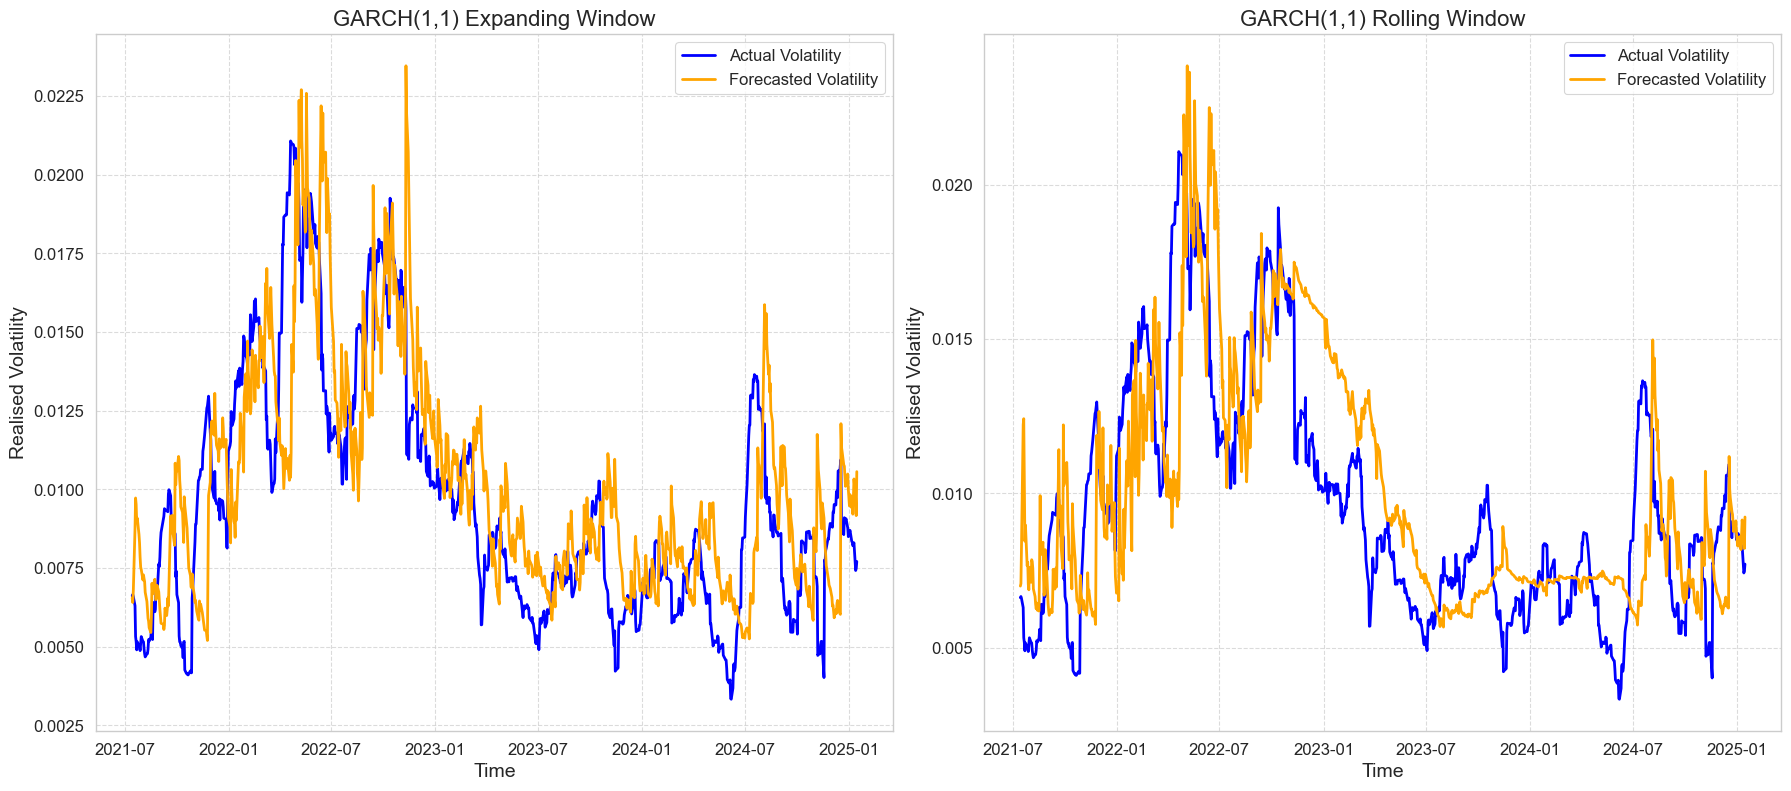

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 8))

vis_pred(RV_test, gm_best_forecast_test_exp['Vol-1'], 'GARCH(1,1) Expanding Window', ax[0])
vis_pred(RV_test, gm_best_forecast_test['Vol-1'], 'GARCH(1,1) Rolling Window', ax[1])

plt.tight_layout()
plt.savefig('figures/GARCH_roll_exp_plot.png', dpi = 300)
plt.show()

## 1c. Deep Feed-Forward Networks 

In [86]:
def train_one_epoch(model, train_loader, optimiser, loss_fn = 'MAE', device = None): 
    '''
    Calculate weights/bias that minimise training loss. 
    
    Args:
    - Model: torch.nn.Module, the model to train
    - train_loader : train data loader 
    - optimiser torch.optim.Optimizer optimiser to use for backprop
    - loss_fn : loss function, string, either MAE, MSE
    - device (torch.device): device to move data/model to
    Returns:
    - training_loss - average loss over epoch
    '''
    # Only needed if train on GPU
    if device:
        model.to(device)
    
    model.train() # Allows for params to update
    training_loss = 0.0 # Tracks average loss per batch
    
    # Define our loss function, allow for customisation
    if loss_fn == 'MAE':
        loss_fn = nn.L1Loss()

    if loss_fn == 'MSE':  
        loss_fn = nn.MSELoss()

    for X, y_true in train_loader: 
        # Send batch to GPU
        if device:
            X, y_true = X.to(device), y_true.to(device)
        
        optimiser.zero_grad() 
        
        # Make prediction and calculate loss
        y_pred = model(X)
        loss = loss_fn(y_pred,y_true)
        
        # Backpropagation
        loss.backward() 
        optimiser.step() 
        
        training_loss += loss.item() # Accumulate training loss per batch
        
    return training_loss / len(train_loader) # Returns the average loss (per batch) for training set

In [87]:
def validate_one_epoch(model, val_loader, loss_fn = 'MAE' ,return_hmae = False, device = None): 
    '''
    Calculate validation loss for trained model.
    
    Args:
    - Model: torch.nn.Module, the model to train
    - val_loader : val data loader 
    - optimiser torch.optim.Optimizer optimiser to use for backprop
    - loss_fn : loss function, string, either MAE, MSE
    -'return_hmae': If true will return hmae (accuracy) for predictions 
    - device (torch.device): device to move data/model to
    Returns:
    - training_loss - average loss over epoch
    '''
    if device:
        model.to(device)
    
    model.eval()
    
    pred, actuals = [], [] 
    running_loss = 0.0
    
    # Define our loss function 
    if loss_fn == 'MAE':
        loss_fn = nn.L1Loss()
    if loss_fn == 'MSE':
        loss_fn = nn.MSELoss()

    with torch.no_grad(): # No gradient calculation
        for X,y_true in val_loader: 
            # Send batch to GPU
            if device:
                X, y_true = X.to(device), y_true.to(device)
            # Get prediction
            y_pred = model(X) 
            
            # Get the current loss (Validation MSE)
            loss = loss_fn(y_pred, y_true)
            running_loss += loss.item()
            
            # Get the predicitons and actuals on val data
            pred.append(y_pred.detach().cpu().numpy())
            actuals.append(y_true.detach().cpu().numpy())  
      
    # Find average val loss across batches
    val_loss = running_loss / len(val_loader)
    
    # Compute accuracy
    if return_hmae: 
        # Find HMAE for epoch
        pred = np.concatenate(pred, axis=0)  # Stack all predictions, one long numpy array
        actuals = np.concatenate(actuals, axis=0)  # Stack all actual values
        
        return val_loss, hmae(actuals, pred) 
    
    return val_loss

In [88]:
def load_best_model(model, model_path, device = None):
    '''
    Input in the model framework. Loads the final weights/biases onto the model framework. 
    '''
    if device: 
        state_dict = torch.load(model_path, weights_only=True, map_location = device)
    else: 
        state_dict = torch.load(model_path, weights_only=True)
        
    model.load_state_dict(state_dict)
    model.eval() 
    print(f"Loaded the model from {model_path}")
    return model

In [89]:
def plot_train_val_loss(history): 
    '''
    Takes in dictionary of average training and val loss per epochs.
    Plot the training and validation loss. Helps identitfy over or underfitting. 
    '''
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [90]:
def evaluate_model(model, dataloader, test_type = 'Validation', device = None): 
    '''
    Args 
    - model (torch.nn.Module), trained model
    - dataloader ; val or test data
    -test_type: for plot title, validation or test data?
    - device : CPU or GPU?
    Returns: 
    - predictions, numpy array of model predictions over data 
    - actuals, numpy array of target
    
    Evaluated a model over data. No updating of gradients/training. 
    Plots predictions and finds HMAE and HMSE. 
    Returns predictions and actuals 
    '''
    if device:
        model.to(device)
    
    model.eval()  
    predictions, actuals = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            if device:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
            curr_pred = model(X_batch) 
            
            # Convert to numpy and append to lists
            predictions.append(curr_pred.cpu().numpy()) 
            actuals.append(y_batch.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)  # Stack all predictions
    actuals = np.concatenate(actuals, axis=0)  # Stack all actual values
        
    # Find HMSE and HMAE for model with best weights/bias; final HMAE/HMSE on val/test set
    model_hmae = hmae(actuals, predictions)
    model_hmse = hmse(actuals, predictions)
    
    # Plot predictions
    plt.figure(figsize=(8, 5))
    plt.plot(actuals, label="21-Day Realised Volatility (RV)")
    plt.plot(predictions, label="Forecasted Volatility by Model")
    plt.ylabel("Volatility")
    plt.title(f"Realised Volatility Forecasts vs Actual Values over {test_type} Data")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'{test_type} HMAE: {model_hmae}\t {test_type} HMSE: {model_hmse}')

    return predictions, actuals 

In [91]:
def train_model(model, train_loader, val_loader, lr, loss_fn='MAE' ,early_stop = 75, max_epochs = 200, device = None):   
    """
    Trains a PyTorch model using early stopping based on validation loss.
    Args: 
    model : Pytorch model to train
    train_loader : train dataloader
    val_loader : validation dataloader
    lr : float, learning rate
    loss_fn : str, default = 'MAE', loss function to use
    early_stop : int, default = 75, num of epochs to wait without improvement on validation loss before stopping.
    max_epochs : int, default = 200, maximum number of training epochs.
    device : torch.device or None
    
    Returns:
    model_path : str, file path to the best saved model (based on lowest validation loss).
    """
    best_loss = np.Inf # Tracks our best Validation Loss, used for early stopping
    patience = 0 # For early stopping
    best_epochs = 0 # Saves where best epoch occrus
    
    if device:
        model.to(device)
    
    # Setup Adam optimiser
    optimiser = optim.Adam(model.parameters(), lr) 
    
    # Track Train and Val loss 
    history = {'train_loss': [], 'val_loss':[]} 
    
    # Define test name and file path
    test_name = model.name()
    model_path = f'{test_name}.pth'
    
    # Check model parameters and learning rate
    print(f'Learning Rate: {lr}')
    # Track time taken
    print(f'Starting training...\n')
    start = time.time()
    
    for epoch in range(max_epochs): 
        
        # Train model and obtain validation loss each epoch 
        train_loss = train_one_epoch(model, train_loader, optimiser, loss_fn = loss_fn, device=device)
        val_loss  = validate_one_epoch(model, val_loader, loss_fn = loss_fn , return_hmae = False, device = device)
        
        # Append new train and validation loss
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # If Validation Loss hasn't improved should we early stop?
        if val_loss >= best_loss:
            patience += 1
            # Early stopping based on validation loss; prevents overfitting
            if patience >= early_stop: # Early stopping to prevent overfitting
                print(f'Early stopping triggered after {epoch+1} epochs.\n')
                break
        
        # If validation Loss has improved update best loss
        else: 
            # Track everytime validation loss descreases
            #print(f'Epoch:{epoch+1}/{max_epochs}: Training Loss: {train_loss:.8f} \t Validation/Test loss decreased ({best_loss:.8f} --> {val_loss:.8f}).\n')
            best_loss = val_loss 
            best_epochs = epoch+1
            # Reset patience
            patience = 0 
            # Save better model 
            torch.save(model.state_dict(), model_path)
    
    # Print total time to run
    total_time = time.time() - start 
    print(f'\nTraining Completed in {total_time:.2f} seconds')
    
    # Report lowest val loss and corresponding epoch
    print(f'\nBest Validation Loss: {best_loss} at epoch {best_epochs}') 
    
    # Plot train val loss
    plot_train_val_loss(history)
       
    return model_path

In [92]:
def final_model_test(model, train_val_loader, test_loader, lr, best_epoch ,loss_fn='MAE',device = None):   
    '''
    Args 
    - model
    - train_val_loader: data loader with train + val data 
    - test_loader: data loader with test data 
    - lr : float, learning rate for optimiser
    - best_epoch, last epoch where val loss improved 
    - loss_fn, default 'MAE'
    - device 
    
    Returns 
    - model_path, str 
    - preds, numpy array
    - actuals, numpy array
    '''
    if device:
        model.to(device)
    
    # Setup Adam optimiser
    optimiser = optim.Adam(model.parameters(), lr) 
    
    # Define test name and file path
    test_name = model.name()
    model_path = f'{test_name}.pth'
    
    # Check model parameters and learning rate
    print(f'Model Parameters: {model.parameters}\nLearning Rate: {lr}')
    
    # Track time
    print(f'Starting training...\n')
    start = time.time()   
    
    for epoch in range(best_epoch): 
        # Train the model
        _ = train_one_epoch(model, train_val_loader, optimiser, loss_fn = loss_fn, device = device)
    
    # Print total time to run
    total_time = time.time() - start 
    print(f'\nTraining Completed in {total_time:.2f} seconds')
    # Save model after training 
    torch.save(model.state_dict(), model_path)
    
    preds, actuals = evaluate_model(model, test_loader, test_type = 'Test')
    
    # Return model path saved on train/test
    return model_path, preds, actuals

In [93]:
def create_wrapper(func, *fixed_args, **fixed_kwargs):
    '''
    Used to wrap the objective function to allow us to pass multiple arguements in. 
    '''
    return partial(func, *fixed_args, **fixed_kwargs)

## 2a. Data Preprocessing and Feature Engineering

In [94]:
input_var = spx_df2.copy()[['Log Return', 'Log Return Squared', 'High Low Range']]

In [95]:
input_var = input_var.reset_index() # Numeric index 

In [96]:
input_var

Date  Log Return  Log Return Squared  High Low Range
0    2000-01-03   -0.009595        9.206392e-05        0.027186
1    2000-01-04   -0.039099        1.528746e-03        0.040522
2    2000-01-05    0.001920        3.687698e-06        0.025505
3    2000-01-06    0.000955        9.124486e-07        0.014123
4    2000-01-07    0.026730        7.144902e-04        0.028670
...         ...         ...                 ...             ...
6293 2025-01-08    0.001559        2.430930e-06        0.009000
6294 2025-01-10   -0.015532        2.412318e-04        0.014117
6295 2025-01-13    0.001574        2.478119e-06        0.011247
6296 2025-01-14    0.001146        1.312453e-06        0.011390
6297 2025-01-15    0.018147        3.293184e-04        0.009338

[6298 rows x 4 columns]

### 3a. GARCH Forecast Generation

This is for our hybrid model later down the linear. We will use GARCH(1,1) with Constant Mean Equation on a rolling 504 day window. 

In [97]:
def garch_hybrid_data(series,p_order,q_order,mean_eq,dist_eq, fixed_window_size = fixed_window_size): 
    '''
    Input: 
        - series (ensure integer index)
        - GARCH model parameters (p_order, q_order, mean_eq, dist_eq)
    Output:
        - A DataFrame containing the forecasted volatility and estimated parameters.
    '''
    set_seed_all()
    T = 1 # Time horizon is just one ahead 
    start_idx = fixed_window_size # Window size 
    print(f'Window size:{fixed_window_size}')
    
    # Obtain the names of the parameters used in the model
    initial_model = arch_model(series[:start_idx], p=p_order, q=q_order, mean=mean_eq, dist=dist_eq, rescale=True)
    initial_fit = initial_model.fit(disp='off')
    coef_names = initial_fit.params.index.tolist()  # Extract parameter names
            
    # Create our dataframe to hold one day ahead forecasts and coeffcient names 
    hybrid_forecast = pd.DataFrame(columns=['forecast'] + coef_names)
        
    for i in range(len(series)-start_idx):
        train = series[i:i+start_idx]# Rolling window training set 
        
        model = arch_model(
                train, 
                p = p_order,
                q = q_order,
                mean = mean_eq, 
                rescale = True, 
                dist = dist_eq
                )
        model_fit = model.fit(disp = 'off')
        
        # Find the forecast for the next day and append to Forecast columns 
        new_forecast = np.sqrt(model_fit.forecast(horizon=1).variance.iloc[-1, 0]) / model_fit.scale
        
        # Extract the parameters and append to corresponding coef for t 
        new_params = model_fit.params.tolist() 
        
        # Append forecast and params to dataframe
        hybrid_forecast.loc[i] = [new_forecast] + new_params
        
    return hybrid_forecast

In [98]:
garch_input = garch_hybrid_data(series=input_var['Log Return'],p_order=1,q_order=1,mean_eq='Zero',dist_eq='Normal')

Window size:252


In [99]:
garch_input.head()

forecast     omega  alpha[1]   beta[1]
0  0.014992  0.036263  0.073867  0.909652
1  0.016525  0.035091  0.077498  0.907912
2  0.022147  0.029590  0.091400  0.903809
3  0.021239  0.029358  0.089639  0.904831
4  0.021970  0.029217  0.093195  0.901903

In [100]:
garch_input.shape

(6046, 4)

In [101]:
input_var.shape

(6298, 4)

### 3b. Establishing features and targets for neural networks

Note we have lose the first 252 observations in order to fit the model. Input_var will be our dataframe of all input variables into the neural networks

In [102]:
input_var = input_var[fixed_window_size:] # Drop first window size observations used to train GARCH 

In [103]:
date_index = input_var['Date'] # Save date index for future plotting 

In [104]:
input_var = input_var.drop(columns = ['Date'])

In [105]:
input_var = input_var.reset_index(drop = True)

In [106]:
input_var = pd.concat([input_var,garch_input], axis =1) # Add GARCH input to input_var table

In [107]:
input_var.head()

Log Return  Log Return Squared  High Low Range  forecast     omega  \
0   -0.028432            0.000808        0.034074  0.014992  0.036263   
1    0.048884            0.002390        0.055796  0.016525  0.035091   
2   -0.010609            0.000113        0.015750  0.022147  0.029590   
3   -0.026593            0.000707        0.030287  0.021239  0.029358   
4   -0.001920            0.000004        0.017137  0.021970  0.029217   

   alpha[1]   beta[1]  
0  0.073867  0.909652  
1  0.077498  0.907912  
2  0.091400  0.903809  
3  0.089639  0.904831  
4  0.093195  0.901903

**Target Variable Dataframe**

In [108]:
target_var = spx_df2['Future RV-21']

In [109]:
target_var = target_var[fixed_window_size:] 

In [110]:
target_var = pd.DataFrame(target_var)

In [111]:
target_var = target_var.reset_index(drop = True)

In [112]:
target_var

Future RV-21
0         0.015113
1         0.013546
2         0.009744
3         0.009468
4         0.007272
...            ...
6041      0.008211
6042      0.008302
6043      0.007422
6044      0.007489
6045      0.007709

[6046 rows x 1 columns]

### 3c. Investigating correlation between potential input variables and target

In [113]:
corr_matrix_vars = (pd.concat([input_var.drop(columns=['omega','alpha[1]','beta[1]']),target_var], axis =1)).corr()

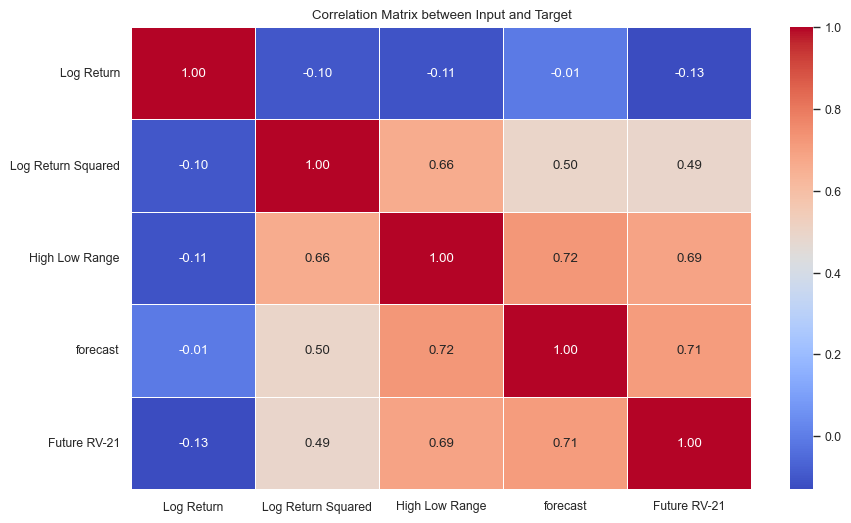

In [114]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_vars, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix between Input and Target")
plt.savefig('figures/correlation_input_var.png', dpi = 300)
plt.show()

It seems that it might be wise to do as follows
1. Datasubset1 : Log Returns Squared (Base variables)
2. Datasubset2: Log Returns Squared + GARCH Forecast (Base + Hybrid Variables)
3. Datasubset3: Log Returns Squared + GARCH Forecast + High Low Range 

### 3d. Create new train, validation and test data 

In [115]:
train_size_new = len(train_idx[fixed_window_size:]) # Number of samples in new training set (-n. window size observations)

In [116]:
# Create DataFrame summarising the dataset split
data_split_summary = pd.DataFrame({
    'Set': ['Train (Original)', 'Train (New)', 'Validation', 'Test'],
    'Size': [train_size, train_size_new, val_size, test_size],
    'Percentage of Full Dataset': [
        train_size / len(spx_df2) * 100,
        train_size_new / len(spx_df2) * 100,
        val_size / len(spx_df2) * 100,
        test_size / len(spx_df2) * 100
    ],
    'Percentage of Updated Dataset': [
        None,
        train_size_new / len(input_var) * 100,
        val_size / len(input_var) * 100,
        test_size / len(input_var) * 100
    ]
})

data_split_summary.to_excel('data_split_new_summary.xlsx', index=False)

In [117]:
reduction_pct = fixed_window_size / len(spx_df2) * 100
print(f'Reduction in training size:{reduction_pct}')

Reduction in training size:4.00127024452207


In [118]:
data_split_summary

Set  Size  Percentage of Full Dataset  \
0  Train (Original)  4534                   71.991108   
1       Train (New)  4282                   67.989838   
2        Validation   882                   14.004446   
3              Test   882                   14.004446   

   Percentage of Updated Dataset  
0                            NaN  
1                      70.823685  
2                      14.588157  
3                      14.588157

In [119]:
def train_test_split_df(df, n_train, n_val, n_test): 
    '''
    Takes in Pandas Dataframe and splits into train/val/test split based on number obs in each. 
    Returns as numpy array.
    '''
    df = df.to_numpy()
    
    train = df[:n_train]
    val = df[n_train:n_train+n_val]
    test = df[n_train+n_val:]
    
    return train, val, test

In [120]:
def scale_input(train_data, val_data, test_data, scaler):    
    train_scaled = scaler.fit_transform(train_data)  # Fit and transform train data
    
    val_scaled = scaler.transform(val_data) # Use fitted scalar to transform data

    test_scaled = scaler.transform(test_data)

    return train_scaled, val_scaled, test_scaled, scaler  # Returns np.arrays and scalar (for inverse transform)

In [121]:
def rescale(scaled_data, scaler):
    '''
    Function to rescale a numpy array back into original scale. I don't actually need this but I created it 
    just so I can check the scaler and inverse_transform works as expected.
    '''
    return scaler.inverse_transform(scaled_data)

In [122]:
# Split into train, val and test split
X_train, X_val, X_test = train_test_split_df(input_var,train_size_new,val_size,test_size)
y_train, y_val, y_test = train_test_split_df(target_var,train_size_new,val_size,test_size)

**Creating datasubset1**

In [123]:
input_var.columns[1]

'Log Return Squared'

In [124]:
X_train[:,1].shape

(4282,)

In [125]:
# Needs to be reshaped such that it is 2D not 1D
lr2_train, lr2_val, lr2_test = X_train[:,1].reshape(-1,1), X_val[:,1].reshape(-1,1), X_test[:,1].reshape(-1,1)

In [126]:
scaler = MinMaxScaler()
lr2_train_sc, lr2_val_sc, lr2_test_sc, scaler_lr2 = scale_input(lr2_train, lr2_val, lr2_test, scaler)

In [127]:
# SANITY CHECK that rescale works, np.isclose to account for rounding error
comparison = np.isclose(rescale(lr2_train_sc, scaler_lr2), lr2_train, atol=1e-6) 

print(f'True count: {np.sum(comparison)}')
print(f'False count: {comparison.size - np.sum(comparison)}')

True count: 4282
False count: 0


**Creating datasubset2**

In [128]:
input_var.columns[1],input_var.columns[3]

('Log Return Squared', 'forecast')

In [129]:
lr2_garch_train, lr2_garch_val, lr2_garch_test = X_train[:,[1,3]], X_val[:,[1,3]], X_test[:,[1,3]]

In [130]:
scaler = MinMaxScaler()
lr2_garch_train_sc, lr2_garch_val_sc, lr2_garch_test_sc, scaler_lr2_garch = scale_input(lr2_garch_train, 
                                                                                        lr2_garch_val, 
                                                                                        lr2_garch_test, 
                                                                                        scaler)

**Creating datasubset3**

In [131]:
input_var.columns[1],input_var.columns[0], input_var.columns[3]

('Log Return Squared', 'Log Return', 'forecast')

In [132]:
all_train, all_val, all_test = X_train[:,[0,1,3]], X_val[:,[0,1,3]], X_test[:,[0,1,3]]

In [133]:
scaler = MinMaxScaler()
all_train_sc, all_val_sc, all_test_sc, scaler_all = scale_input(all_train, all_val, all_test, scaler)

### 3e. Turning into supervised data 

In [134]:
def to_supervised(X_data,y_data,n_in,n_out): 
    '''
    Turns input and target numpy arrays into windowed format. Returns it as a torch. 
    E.g. t-21 to t-1 of X inputs one window and RV for day t in corresponding y 
    '''
    X,y = list(), list()
    in_start = 0 # Start of input 
    
    for _ in range(len(X_data)): # Go over all of data
        in_end = in_start + n_in # End of input 
        out_end = in_end + n_out # End of output sequence 
        if out_end <= len(y_data): 
            X.append(X_data[in_start:in_end,:]) # Lookback window; select all columns 
            y.append(y_data[in_end:out_end]) # Forecast horizon
        in_start += 1 
    
    X,y = np.array(X), np.array(y) 
            
    return torch.tensor(X).float(), torch.tensor(y).float().squeeze(-1) 

In [135]:
def format_data(X_data, y_data, batch_size, n_in, n_out, case):
    '''
    Formats supervised data in dataloader format. 
    '''
    ### FORMAT TO WINDOWED ###
    if case == 'MLP' or case == 'Linear':
        (X_data, y_data)= to_supervised(X_data, y_data, n_in, n_out)
        X_data = X_data.reshape(X_data.shape[0], -1) # Ensure 2D shape for Linear/MLP
    else: 
        (X_data, y_data)= to_supervised(X_data, y_data, n_in, n_out)

    ### FORMATTING THE DATALOADER ###
    dataset = TensorDataset(X_data, y_data)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)
    
    ### SANITY CHECK: ENSURING SHAPES ARE COMPATIBLE ###
    inputs,targets = next(iter(dataloader))
    print(f'Input Shape: {inputs.shape}, Output Shape: {targets.shape}')
    
    return dataloader 

In [136]:
# Global configerations these can be changed down the line
batch_size = 128

In [137]:
# Format data for univariate -> dataloader for MLP
lr2_train_dl = format_data(lr2_train_sc, y_train, batch_size, 21, 1, case = 'MLP')
lr2_val_dl = format_data(lr2_val_sc, y_val, batch_size, 21, 1, case = 'MLP')

Input Shape: torch.Size([128, 21]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21]), Output Shape: torch.Size([128, 1])


In [138]:
# Dataloader for dataset 1 for lstm
lr2_train_lstm_dl = format_data(lr2_train_sc, y_train, batch_size, 21, 1, case = 'LSTM')
lr2_val_lstm_dl = format_data(lr2_val_sc, y_val, batch_size, 21, 1, case = 'LSTM')

Input Shape: torch.Size([128, 21, 1]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 1]), Output Shape: torch.Size([128, 1])


In [139]:
# Dataloader for dataset 2 
garch_train_dl = format_data(lr2_garch_train_sc, y_train, batch_size, 21, 1, case = 'MLP')
garch_val_dl = format_data(lr2_garch_val_sc, y_val, batch_size, 21, 1, case = 'MLP')

Input Shape: torch.Size([128, 42]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 42]), Output Shape: torch.Size([128, 1])


In [140]:
# Dataloader for dataset 2 LSTM
garch_train_lstm_dl = format_data(lr2_garch_train_sc, y_train, batch_size , 21, 1, 'LSTM')
garch_val_lstm_dl = format_data(lr2_garch_val_sc, y_val, batch_size, 21, 1, 'LSTM')

Input Shape: torch.Size([128, 21, 2]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 2]), Output Shape: torch.Size([128, 1])


In [141]:
# Dataloader for dataset 3 MLP
all_train_dl = format_data(all_train_sc, y_train, batch_size, 21, 1, case = 'MLP')
all_val_dl = format_data(all_val_sc, y_val, batch_size, 21, 1, case = 'MLP')

Input Shape: torch.Size([128, 63]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 63]), Output Shape: torch.Size([128, 1])


In [142]:
# Dataloader for dataset 3 LSTM
all_train_lstm_dl = format_data(all_train_sc, y_train, batch_size, 21, 1, case = 'LSTM')
all_val_lstm_dl = format_data(all_val_sc, y_val, batch_size, 21, 1, case = 'LSTM')

Input Shape: torch.Size([128, 21, 3]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 3]), Output Shape: torch.Size([128, 1])


Dataloaders for final testing

In [143]:
# Create train + val dataset which will be used to train all models on 
X_train_val = np.vstack([X_train, X_val])

In [144]:
# Create train + val target data set
y_train_val = np.vstack([y_train, y_val])

In [145]:
# Select LR2 
lr2_train_val = X_train_val[:, 1].reshape(-1,1)

# Apply the scalar 
scaler = MinMaxScaler()

# Fit scalar to train + val
lr2_train_val_sc = scaler.fit_transform(lr2_train_val)
# Apply scalar to test data
lr2_test_sc = scaler.transform(lr2_test)

In [146]:
# Format LR2 dataloader
lr2_train_val_dl = format_data(lr2_train_val_sc, y_train_val, batch_size, 21, 1, 'MLP')
lr2_test_dl = format_data(lr2_test_sc, y_test, batch_size,21,1, 'MLP')

Input Shape: torch.Size([128, 21]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21]), Output Shape: torch.Size([128, 1])


In [147]:
# Format LR2 dataloader for LSTM
lr2_train_val_lstm_dl = format_data(lr2_train_val_sc, y_train_val, batch_size, 21, 1, 'LSTM')
lr2_test_lstm_dl = format_data(lr2_test_sc, y_test, batch_size, 21,1, 'LSTM')

Input Shape: torch.Size([128, 21, 1]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 1]), Output Shape: torch.Size([128, 1])


In [148]:
# Select LR2 + GARCH Forecast
garch_train_val = X_train_val[:, [1,3]]

scalar = MinMaxScaler()

garch_train_val_sc = scalar.fit_transform(garch_train_val)
garch_test_sc = scalar.transform(lr2_garch_test)

In [149]:
# Format GARCH-LR2 dataloader 
garch_train_val_dl = format_data(garch_train_val_sc, y_train_val, batch_size, 21, 1, 'MLP')

garch_test_dl = format_data(garch_test_sc, y_test, batch_size,21,1, 'MLP')

Input Shape: torch.Size([128, 42]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 42]), Output Shape: torch.Size([128, 1])


In [150]:
# Format GARCH-LR2 dataloader for LSTM
garch_train_val_lstm_dl = format_data(garch_train_val_sc, y_train_val, batch_size, 21, 1, 'LSTM')

garch_test_lstm_dl = format_data(garch_test_sc, y_test, batch_size,21,1, 'LSTM')

Input Shape: torch.Size([128, 21, 2]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 2]), Output Shape: torch.Size([128, 1])


In [151]:
# Select LR2 + GARCH + Extra vas Forecast
all_train_val = X_train_val[:, [0,1,3]]
all_test = X_test[:,[0,1,3]]

scalar = MinMaxScaler()

all_train_val_sc = scalar.fit_transform(all_train_val)
all_test_sc = scalar.transform(all_test)

In [152]:
# Format GARCH-LR2 + Extra vars dataloader 
all_train_val_dl = format_data(all_train_val_sc, y_train_val, batch_size, 21, 1, 'MLP')

all_test_dl = format_data(all_test_sc, y_test, batch_size,21,1, 'MLP')

Input Shape: torch.Size([128, 63]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 63]), Output Shape: torch.Size([128, 1])


In [153]:
# Format GARCH-LR2 + Extra vars dataloader for LSTM
all_train_val_lstm_dl = format_data(all_train_val_sc, y_train_val, batch_size, 21, 1, 'LSTM')

all_test_lstm_dl = format_data(all_test_sc, y_test, batch_size,21,1, 'LSTM')

Input Shape: torch.Size([128, 21, 3]), Output Shape: torch.Size([128, 1])
Input Shape: torch.Size([128, 21, 3]), Output Shape: torch.Size([128, 1])


## 2b. MLPs

Plot the ReLu function for my paper:

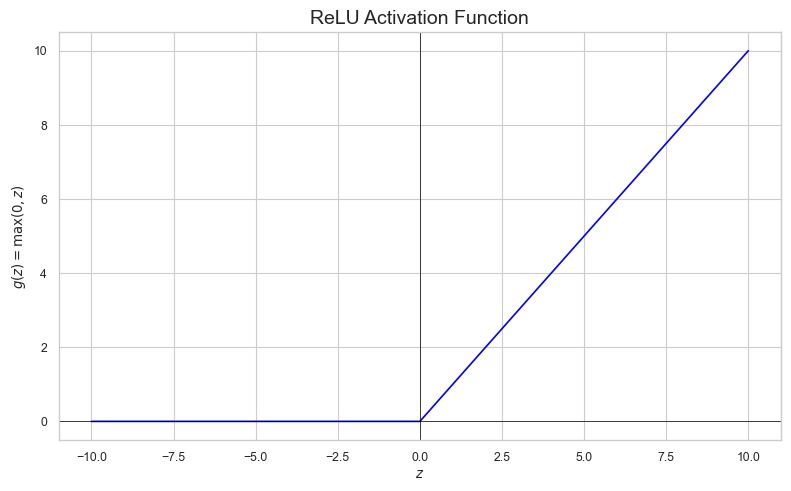

In [154]:
def relu(z):
    return np.maximum(0, z)

z = np.linspace(-10, 10, 1000)
relu_values = relu(z)

plt.figure(figsize=(8, 5))
sns.lineplot(x=z, y=relu_values, color="blue")
plt.title("ReLU Activation Function", fontsize=14)
plt.xlabel("$z$")
plt.ylabel("$g(z) = \max(0, z)$")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()

plt.savefig("figures/relu_function_plot.png")
plt.show()

In [155]:
# Created an MLP with x hidden layers 
class CustomMLP(nn.Module): 
    def __init__(self, input_size, hidden_sizes, output_size, dropout, model_name): 
        '''
        To initialize the MLP, need input size, hidden sizes (list; e.g. [64,32], would be) two hidden layers with
        64 and 32 units respectively, output size and a name for the model/path. 
        '''
        super().__init__()
        
        self.model_name = model_name
        
        # Hold linear layers 
        layers = [] 
        # Initialise current input 
        prev_size = input_size 
        
        # Handle dropout length mismatch; pad if needed
        if len(dropout) < len(hidden_sizes):
            dropout = dropout + [0.0] * (len(hidden_sizes) - len(dropout))
        
        for i, h_size in enumerate(hidden_sizes): 
            layers.append(nn.Linear(prev_size,h_size))
            layers.append(nn.ReLU())
            if dropout[i] > 0:
                layers.append(nn.Dropout(p=dropout[i]))  # Add dropout if > 0
            prev_size = hidden_sizes[i]
        
        # Output layer 
        layers.append(nn.Linear(prev_size, output_size))
        
        # "*" unpacks the layers and loads into Sequential, cool hack!
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self,x): 
        x = self.linear_relu_stack(x)
        return x 
    
    # Additional method which prints model structure 
    def summary(self): 
        print(f'Model Name/Path:{self.model_name}\n')        
        total_params = 0
        for name, param in self.named_parameters(): 
            param_count = param.numel() 
            total_params += param_count 
            print(f'Layer: {name}')
            print(f'  - Size: {param.size()}')
            print(f'  - Number of parameters: {param_count}\n')

        print(f'Total Parameters: {total_params}')
    def name(self):
        return self.model_name

### 3a. Evaluate the best loss function and batch size 

In [156]:
'''# Find average HMAE and HMSE across various seeds
seed_list = [random.randint(0,150) for i in range(0,10)]'''

'# Find average HMAE and HMSE across various seeds\nseed_list = [random.randint(0,150) for i in range(0,10)]'

In [157]:
'''# 4 loss functions we will trial
loss_fn = ['MAE', 'MSE']
# Dataframe to hold results
model_config_perf = pd.DataFrame(columns = ['Loss Function Used', 'Learning Rate', 'Dropout', 'Batch' ,'Avg HMAE', 'StdDev HMAE', 'Avg HMSE', 'StdDev HMSE'])'''

"# 4 loss functions we will trial\nloss_fn = ['MAE', 'MSE']\n# Dataframe to hold results\nmodel_config_perf = pd.DataFrame(columns = ['Loss Function Used', 'Learning Rate', 'Dropout', 'Batch' ,'Avg HMAE', 'StdDev HMAE', 'Avg HMSE', 'StdDev HMSE'])"

In [158]:
'''for batch in [32,64,128]:
    train_dl = format_data(lr2_train_sc, y_train, batch, 21, 1, 'MLP')
    val_dl = format_data(lr2_val_sc, y_val, batch, 21,1,'MLP')
    for loss in loss_fn: 
        hmae_list = []
        hmse_list = []
        for lr in [0.001, 0.0001]:
                for seed in seed_list:
                    set_seed_all(seed)

                    # Build temp model
                    temp_model = CustomMLP(21, [10,5], 1, [0,0], 'Model_Config_Experiment')

                    # Train model 
                    model_path_temp = train_model(temp_model, train_dl, val_dl, lr, loss, early_stop = 10)

                    # Load model
                    temp_model = load_best_model(temp_model, model_path_temp)

                    # Evaluate model
                    temp_pred, temp_actual = evaluate_model(temp_model, val_dl, 'Validation')

                    # Append metric 
                    hmae_list.append(hmae(temp_actual, temp_pred))
                    hmse_list.append(hmse(temp_actual, temp_pred))

                # Find average 
                hmae_avg = np.mean(hmae_list)
                hmse_avg = np.mean(hmse_list)

                hmae_std = np.std(hmae_list)
                hmse_std = np.std(hmse_list)

                new_row = [f'Loss Function: {loss}',
                           f'Learning Rate:{lr}',
                           f'Dropout:{dropout}',
                           f'Batch Size:{batch}',
                           hmae_avg,
                           hmae_std,
                           hmse_avg, 
                           hmse_std]
                # Append to df
                model_config_perf.loc[len(model_config_perf)] = new_row    '''

"for batch in [32,64,128]:\n    train_dl = format_data(lr2_train_sc, y_train, batch, 21, 1, 'MLP')\n    val_dl = format_data(lr2_val_sc, y_val, batch, 21,1,'MLP')\n    for loss in loss_fn: \n        hmae_list = []\n        hmse_list = []\n        for lr in [0.001, 0.0001]:\n                for seed in seed_list:\n                    set_seed_all(seed)\n\n                    # Build temp model\n                    temp_model = CustomMLP(21, [10,5], 1, [0,0], 'Model_Config_Experiment')\n\n                    # Train model \n                    model_path_temp = train_model(temp_model, train_dl, val_dl, lr, loss, early_stop = 10)\n\n                    # Load model\n                    temp_model = load_best_model(temp_model, model_path_temp)\n\n                    # Evaluate model\n                    temp_pred, temp_actual = evaluate_model(temp_model, val_dl, 'Validation')\n\n                    # Append metric \n                    hmae_list.append(hmae(temp_actual, temp_pred))\n      

In [159]:
'''model_config_perf.to_excel('figures/model_config_perf.xlsx')'''

"model_config_perf.to_excel('figures/model_config_perf.xlsx')"

### 3b MLP with LR2

Model Name/Path:Final_MLP

Layer: linear_relu_stack.0.weight
  - Size: torch.Size([14, 21])
  - Number of parameters: 294

Layer: linear_relu_stack.0.bias
  - Size: torch.Size([14])
  - Number of parameters: 14

Layer: linear_relu_stack.3.weight
  - Size: torch.Size([8, 14])
  - Number of parameters: 112

Layer: linear_relu_stack.3.bias
  - Size: torch.Size([8])
  - Number of parameters: 8

Layer: linear_relu_stack.6.weight
  - Size: torch.Size([1, 8])
  - Number of parameters: 8

Layer: linear_relu_stack.6.bias
  - Size: torch.Size([1])
  - Number of parameters: 1

Total Parameters: 437
Learning Rate: 0.001
Starting training...


Training Completed in 5.11 seconds

Best Validation Loss: 0.0040166226182399055 at epoch 167


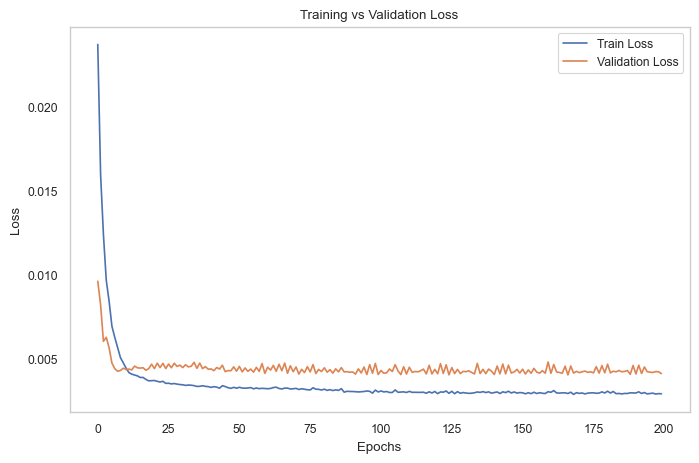

Loaded the model from Final_MLP.pth


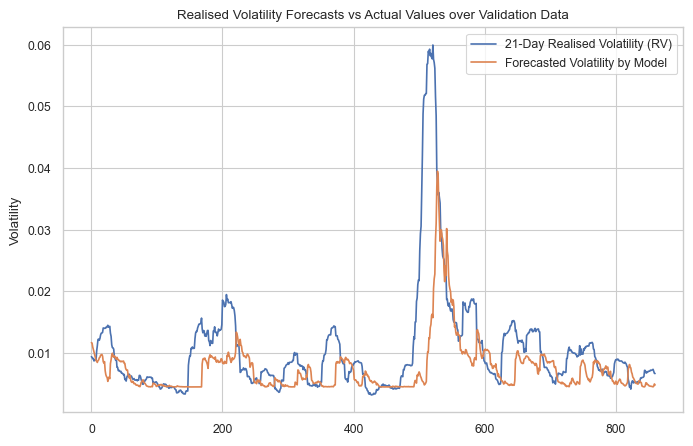

Validation HMAE: 0.3132127821445465	 Validation HMSE: 0.14321044087409973


In [160]:
# Initial hidden nodes and layer number from Kim et al (2018)
set_seed_all()

MLP_model = CustomMLP(21, [14,8], 1, dropout=[0.2,0.1,0.0], model_name = 'Final_MLP')
MLP_model.summary()
MLP_path = train_model(MLP_model, lr2_train_dl, lr2_val_dl, loss_fn ='MAE',lr = 0.001, max_epochs=200)
MLP_model = load_best_model(MLP_model,MLP_path)
MLP_val_pred, MLP_val_actual = evaluate_model(MLP_model, lr2_val_dl)

In [161]:
log_perf(MLP_val_actual, MLP_val_pred, 'MLP LR2 (14,8 , 0.2, 0.1 Dropout)', perf_df, True)

Model Name       MAE      HMAE       MSE  \
0                            Benchmark Model  0.005401  0.479794  0.000086   
1        GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2    GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3      GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4  GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5          MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284  
5  0.143210

### 3c Test MLP

In [162]:
set_seed_all()
MLP_model = CustomMLP(21, [14,8], 1, dropout=[0.2,0.1,0.0], model_name = 'Final_MLP')

Model Parameters: <bound method Module.parameters of CustomMLP(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=14, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=14, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 4.91 seconds


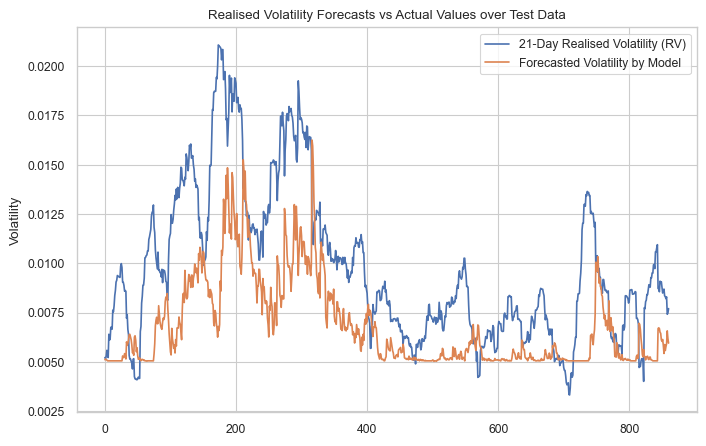

Test HMAE: 0.2916119694709778	 Test HMSE: 0.10941814631223679


In [163]:
# Train on training + val data
MLP_path, MLP_test_pred, MLP_test_actual = final_model_test(MLP_model, lr2_train_val_dl, lr2_test_dl, loss_fn ='MAE',
                                                            lr = 0.001, best_epoch=167)

In [164]:
log_perf(MLP_test_actual, MLP_test_pred, 'MLP (14,8 , 0.2,0.1 Dropout)', perf_test_df, inplace = True, name = 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0               Benchmark Model  0.002447   0.273101  0.000010   0.128265
1            GARCH(1,1) Rolling  0.002388   0.269345  0.000009   0.119719
2          GARCH(1,1) Expanding  0.002258   0.264538  0.000008   0.125679
3  MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   0.109418

# 1d. LSTMs

In [165]:
class StackedLSTM(nn.Module): 
    '''
    Up to 3-layer LSTM with 1-2 fully connected layers 
    '''
    def __init__(self, input_size, hidden_sizes, dropouts, model_name, fc_hidden_size=0):
        super(StackedLSTM, self).__init__()
        
        # Initalise parameters 
        self.model_name = model_name
        self.hidden_sizes = hidden_sizes
        self.dropouts = dropouts
        
        # Check everything  is defined properly
        assert 1 <= len(hidden_sizes) <= 4, "hidden_sizes should be a list of length 1-4"
        assert type(fc_hidden_size) == int, "fc_hidden_size must be an int"
        assert 1 <= len(dropouts) <= 2, "dropouts should be a list of length 1-2"
        for i in range(0,len(dropouts)):
            assert 0 <= dropouts[i] < 1, "dropouts must be within [0,1)"
        
        # Pad lists
        hidden_sizes = hidden_sizes + [0] * (4 - len(hidden_sizes))
        dropouts = dropouts + [0] * (2 - len(dropouts))
        
        # Will hold LSTM and dropout layers 
        self.lstm_layers = nn.ModuleList()
        
        # First LSTM layer; necessary
        self.lstm_layers.append(nn.LSTM(input_size=input_size,
                                        hidden_size=hidden_sizes[0],
                                        batch_first=True))
        
        
        # Optional: second, third and fourth LSTM layers
        for i in range(1, 4):
            if hidden_sizes[i] != 0:
                # Append LSTM layer 
                self.lstm_layers.append(nn.LSTM(input_size=hidden_sizes[i - 1],
                                                hidden_size=hidden_sizes[i],
                                                batch_first=True))
        
        # Get last non-zero hidden size for FC input
        last_hidden_size = hidden_sizes[[idx for idx, h in enumerate(hidden_sizes) if h != 0][-1]]

        # Fully connected layers; option for one or two, if 1 layer fc_hidden_size = 0 
        if fc_hidden_size != 0:
            self.fc_layers = nn.Sequential(
                nn.Dropout(dropouts[0]),
                nn.Linear(last_hidden_size, fc_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropouts[1]),
                nn.Linear(fc_hidden_size, 1)
            )
        else:
            self.fc_layers = nn.Sequential(
                nn.Dropout(dropouts[0]),
                nn.Linear(last_hidden_size, 1)
            )
        
    def forward(self, x):
        # Forward propogation LSTM -> FC -> OUT
        out = x
        for i, lstm in enumerate(self.lstm_layers):
            out, _ = lstm(out)
                
        out = out[:, -1, :]  # Take the last time step, CONFUSED EXPLAIN
        out = self.fc_layers(out)
        return out
    
    def name(self): 
        # Name method
        return self.model_name

## 2a. LSTMs

Learning Rate: 0.001
Starting training...

Early stopping triggered after 173 epochs.


Training Completed in 30.18 seconds

Best Validation Loss: 0.004009443185558277 at epoch 98


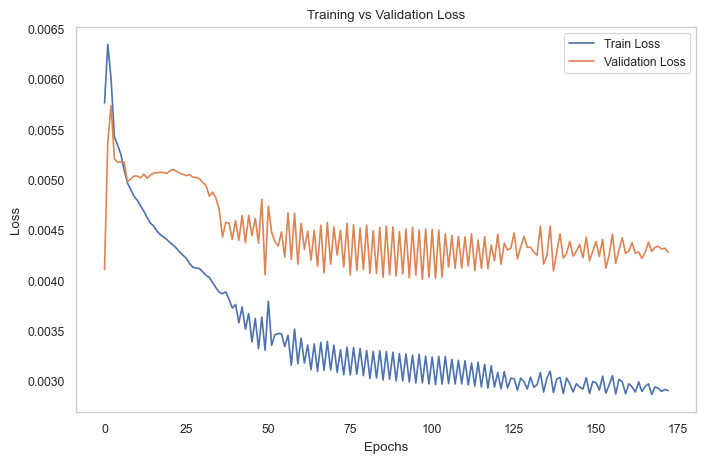

Loaded the model from StackedLSTM_Val.pth


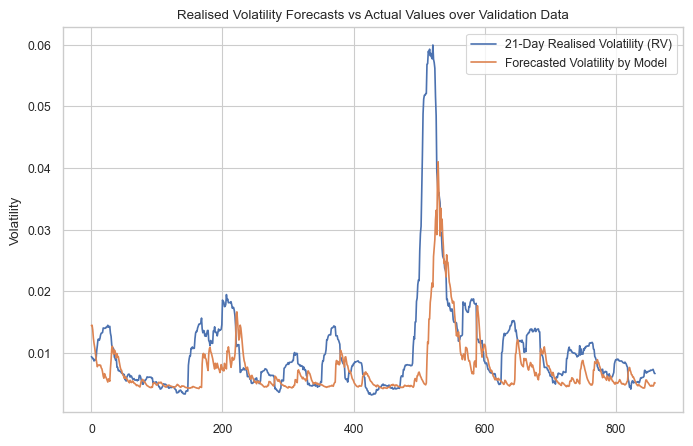

Validation HMAE: 0.3079642951488495	 Validation HMSE: 0.14167165756225586


In [168]:
# Build stacked model
set_seed_all()
lstm_model = StackedLSTM(1, hidden_sizes = [30], dropouts = [0.0,0.0], 
                            model_name = 'StackedLSTM_Val',fc_hidden_size=0)
# Train stacked model
lstm_path = train_model(lstm_model, lr2_train_lstm_dl, lr2_val_lstm_dl, lr= 0.001, 
                        loss_fn = 'MAE', max_epochs= 200)

# Update model with best weights and bias
lstm_model = load_best_model(lstm_model, lstm_path)

# Evaluate model on validation data 
lstm_val_pred, lstm_val_actual = evaluate_model(lstm_model, lr2_val_lstm_dl, 'Validation')

In [169]:
log_perf(lstm_val_actual, lstm_val_pred, 'LSTM (30 Hidden Unit, 0.0 Dropout)', perf_df, True)

Model Name       MAE      HMAE       MSE  \
0                            Benchmark Model  0.005401  0.479794  0.000086   
1        GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2    GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3      GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4  GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5          MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   
6         LSTM (30 Hidden Unit, 0.0 Dropout)  0.004103  0.307964  0.000062   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284  
5  0.143210  
6  0.141672

### 3b. Testing

Model Parameters: <bound method Module.parameters of StackedLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(1, 30, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=30, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 18.81 seconds


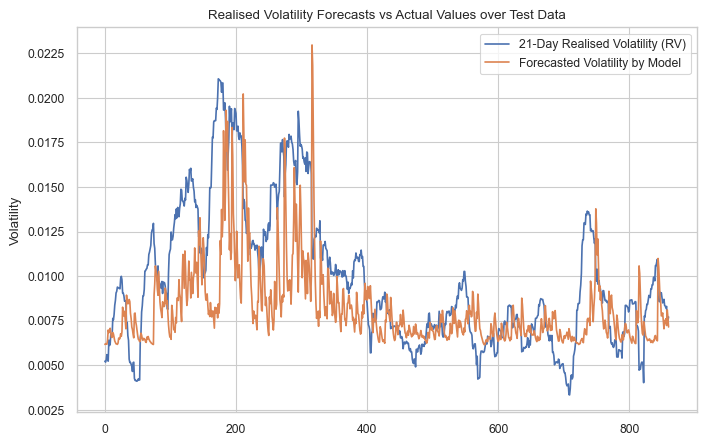

Test HMAE: 0.24767638742923737	 Test HMSE: 0.09649006277322769


In [170]:
# Build stacked model
set_seed_all()
lstm_model = StackedLSTM(1, hidden_sizes = [30], dropouts = [0.0,0], 
                            model_name = 'StackedLSTM_Test',fc_hidden_size=0)

# Evaluate model on validation data 
lstm_test_path, lstm_test_pred, lstm_test_actual = final_model_test(lstm_model, 
                                                                    lr2_train_val_lstm_dl, 
                                                                    lr2_test_lstm_dl,
                                                                    lr = 0.001, 
                                                                    best_epoch=98
                                                                    )

In [171]:
log_perf(lstm_test_actual, lstm_test_pred, 'LSTM (30 Hidden, 0.0 Dropout)',
         perf_test_df, inplace = True, name = 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0                Benchmark Model  0.002447   0.273101  0.000010   0.128265
1             GARCH(1,1) Rolling  0.002388   0.269345  0.000009   0.119719
2           GARCH(1,1) Expanding  0.002258   0.264538  0.000008   0.125679
3   MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   0.109418
4  LSTM (30 Hidden, 0.0 Dropout)  0.002600   0.247676  0.000013   0.096490

# 1e. Hybrid Models 

## 2a. GARCH-DFN 

Learning Rate: 0.001
Starting training...

Early stopping triggered after 106 epochs.


Training Completed in 2.97 seconds

Best Validation Loss: 0.0038781274841832264 at epoch 31


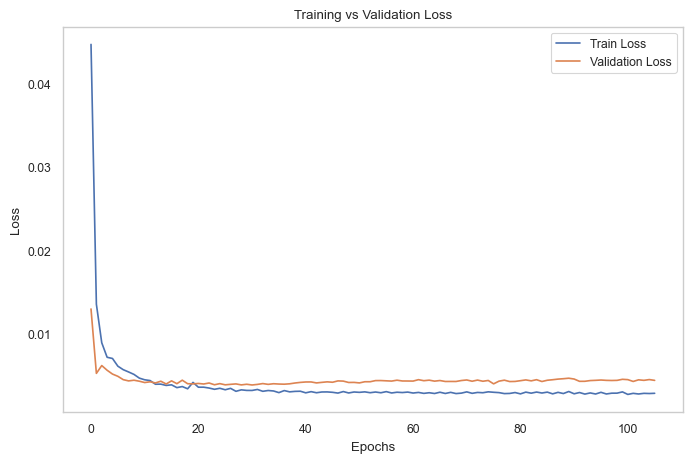

Loaded the model from GARCH-DFN.pth


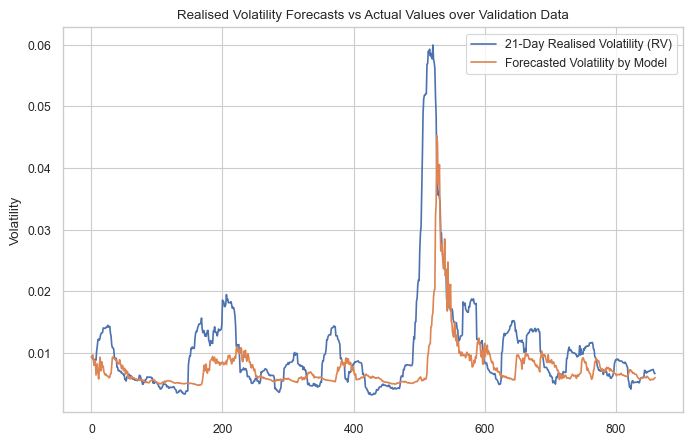

Validation HMAE: 0.3034883737564087	 Validation HMSE: 0.1341220736503601


In [172]:
set_seed_all()
gmlp_model = CustomMLP(input_size = 42, hidden_sizes = [16,8,4], output_size= 1, 
                  dropout = [0.2,0.1,0.0], model_name='GARCH-DFN')

gmlp_path = train_model(gmlp_model, garch_train_dl, garch_val_dl, lr = 0.001, loss_fn = 'MAE')

gmlp_model = load_best_model(gmlp_model, gmlp_path)

gdfn_val_pred, gdfn_val_actual = evaluate_model(gmlp_model, garch_val_dl, 'Validation')

In [173]:
log_perf(gdfn_val_actual, gdfn_val_pred, 'GARCH-DFN(16,8,4 with 0.2,0.1,0 dropout)', perf_df, inplace = True)

Model Name       MAE      HMAE       MSE  \
0                            Benchmark Model  0.005401  0.479794  0.000086   
1        GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2    GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3      GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4  GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5          MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   
6         LSTM (30 Hidden Unit, 0.0 Dropout)  0.004103  0.307964  0.000062   
7   GARCH-DFN(16,8,4 with 0.2,0.1,0 dropout)  0.003987  0.303488  0.000065   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284  
5  0.143210  
6  0.141672  
7  0.134122

### 3b. Testing

Model Parameters: <bound method Module.parameters of CustomMLP(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=42, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 0.97 seconds


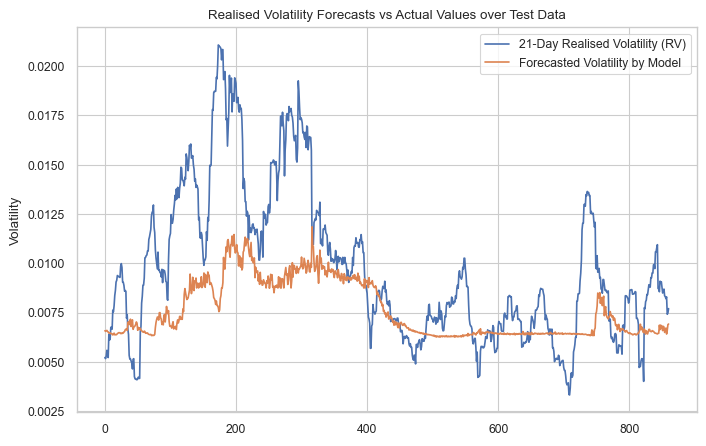

Test HMAE: 0.2411116510629654	 Test HMSE: 0.08563601225614548


In [174]:
set_seed_all()
gmlp_model = CustomMLP(input_size = 42, hidden_sizes = [16,8,4], output_size= 1, 
                  dropout = [0.2,0.1,0.0], model_name='GARCH-DFN')
gmlp_path, gdfn_test_pred, gdfn_test_actual = final_model_test(gmlp_model,garch_train_val_dl, 
                                                       garch_test_dl, lr = 0.001, best_epoch=31)

In [175]:
log_perf(gdfn_test_actual, gdfn_test_pred, 'GARCH-DFN (16,8,4 with 0.2,0.1,0 Dropout)', perf_test_df, inplace = True, name ='Test')

Model Name  Test MAE  Test HMAE  Test MSE  \
0                            Benchmark Model  0.002447   0.273101  0.000010   
1                         GARCH(1,1) Rolling  0.002388   0.269345  0.000009   
2                       GARCH(1,1) Expanding  0.002258   0.264538  0.000008   
3               MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   
4              LSTM (30 Hidden, 0.0 Dropout)  0.002600   0.247676  0.000013   
5  GARCH-DFN (16,8,4 with 0.2,0.1,0 Dropout)  0.002690   0.241112  0.000014   

   Test HMSE  
0   0.128265  
1   0.119719  
2   0.125679  
3   0.109418  
4   0.096490  
5   0.085636

## 2b. GARCH-LSTM 

Learning Rate: 0.001
Starting training...

Early stopping triggered after 181 epochs.


Training Completed in 31.65 seconds

Best Validation Loss: 0.0038948567151757224 at epoch 106


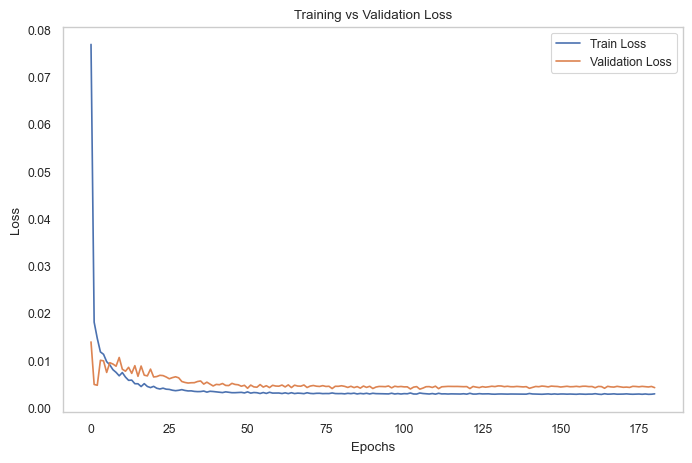

Loaded the model from Stacked_GARCH-LSTM.pth


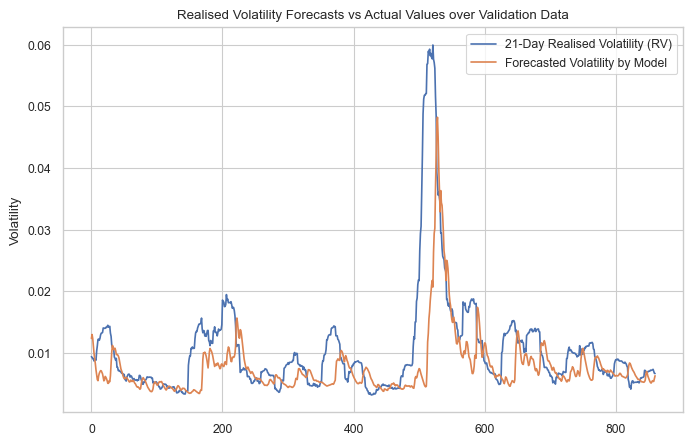

Validation HMAE: 0.3048558533191681	 Validation HMSE: 0.14071911573410034


In [176]:
set_seed_all()
glstm_model = StackedLSTM(2, hidden_sizes = [40], dropouts = [0.2,0.0], model_name = 'Stacked_GARCH-LSTM',
                          fc_hidden_size=16)
glstm_val_path = train_model(glstm_model, garch_train_lstm_dl, garch_val_lstm_dl, lr = 0.001)
glstm_model = load_best_model(glstm_model, glstm_val_path)
glstm_val_pred, glstm_val_actual = evaluate_model(glstm_model, garch_val_lstm_dl, 'Validation')

In [177]:
log_perf(glstm_val_actual, glstm_val_pred, 'GARCH-LSTM (40 with 16 FC layer, 0.2 drop))', perf_df, True)

Model Name       MAE      HMAE       MSE  \
0                              Benchmark Model  0.005401  0.479794  0.000086   
1          GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2      GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3        GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4    GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5            MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   
6           LSTM (30 Hidden Unit, 0.0 Dropout)  0.004103  0.307964  0.000062   
7     GARCH-DFN(16,8,4 with 0.2,0.1,0 dropout)  0.003987  0.303488  0.000065   
8  GARCH-LSTM (40 with 16 FC layer, 0.2 drop))  0.003998  0.304856  0.000060   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284  
5  0.143210  
6  0.141672  
7  0.134122  
8  0.140719

Testing model

Model Parameters: <bound method Module.parameters of StackedLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(2, 40, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=40, out_features=16, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 20.75 seconds


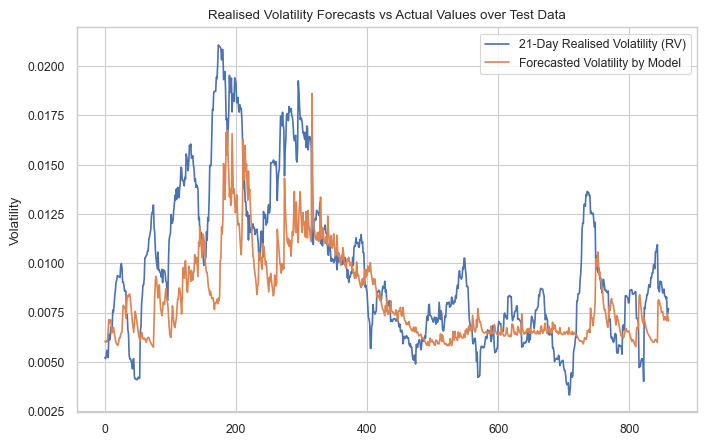

Test HMAE: 0.2266402691602707	 Test HMSE: 0.08045521378517151


In [178]:
# Build stacked model
set_seed_all()
glstm_model = StackedLSTM(2, hidden_sizes = [40], dropouts = [0.2,0.0], model_name = 'Stacked_GARCH-LSTM',
                          fc_hidden_size=16)
glstm_path, glstm_test_pred, glstm_test_actual = final_model_test(glstm_model, 
                                                                  garch_train_val_lstm_dl, 
                                                                  garch_test_lstm_dl, lr = 0.001, best_epoch=106)

In [179]:
log_perf(glstm_test_actual, glstm_test_pred, 'GARCH-LSTM (40 16FC 0.2 dropout)', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  \
0                            Benchmark Model  0.002447   0.273101  0.000010   
1                         GARCH(1,1) Rolling  0.002388   0.269345  0.000009   
2                       GARCH(1,1) Expanding  0.002258   0.264538  0.000008   
3               MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   
4              LSTM (30 Hidden, 0.0 Dropout)  0.002600   0.247676  0.000013   
5  GARCH-DFN (16,8,4 with 0.2,0.1,0 Dropout)  0.002690   0.241112  0.000014   
6           GARCH-LSTM (40 16FC 0.2 dropout)  0.002376   0.226640  0.000011   

   Test HMSE  
0   0.128265  
1   0.119719  
2   0.125679  
3   0.109418  
4   0.096490  
5   0.085636  
6   0.080455

# 1f. All Variables Models 

## 2a. GARCH-DFN + Extra Variables 

Learning Rate: 0.001
Starting training...


Training Completed in 5.67 seconds

Best Validation Loss: 0.0038042773625680377 at epoch 171


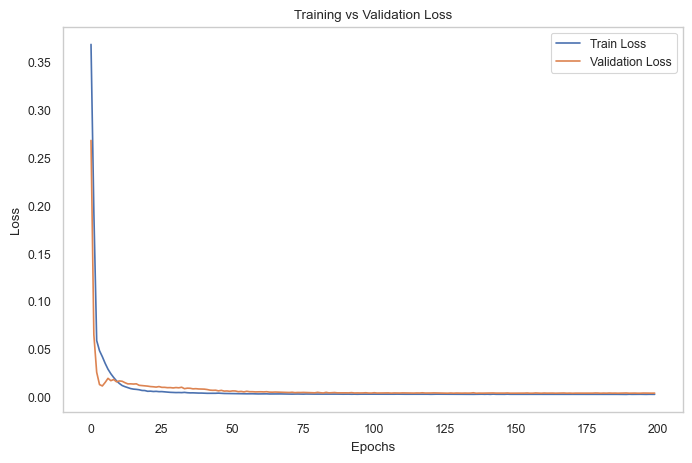

Loaded the model from GARCH-DFN_All.pth


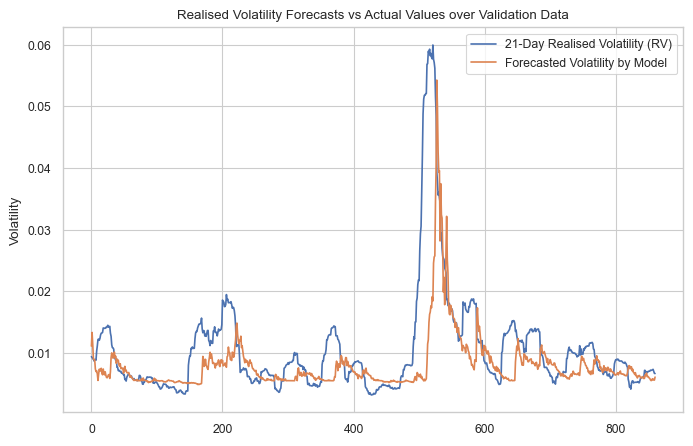

Validation HMAE: 0.30178773403167725	 Validation HMSE: 0.13244612514972687


In [180]:
set_seed_all()
all_gmlp_model = CustomMLP(input_size = 63, hidden_sizes = [16,10,4], 
                           output_size= 1, dropout = [0.2,0.1,0.0], model_name='GARCH-DFN_All')
all_gmlp_path = train_model(all_gmlp_model, all_train_dl, all_val_dl, lr =  0.001, loss_fn = 'MAE')
all_gmlp_model = load_best_model(all_gmlp_model, all_gmlp_path)
gdfn_all_val_pred, gdfn_all_val_actual = evaluate_model(all_gmlp_model, all_val_dl, 'Validation')

In [181]:
log_perf(gdfn_all_val_actual, gdfn_all_val_pred, 'G-DFN All (16,10,4 0.2,0.0)', perf_df, True)

Model Name       MAE      HMAE       MSE  \
0                              Benchmark Model  0.005401  0.479794  0.000086   
1          GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2      GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3        GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4    GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5            MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   
6           LSTM (30 Hidden Unit, 0.0 Dropout)  0.004103  0.307964  0.000062   
7     GARCH-DFN(16,8,4 with 0.2,0.1,0 dropout)  0.003987  0.303488  0.000065   
8  GARCH-LSTM (40 with 16 FC layer, 0.2 drop))  0.003998  0.304856  0.000060   
9                  G-DFN All (16,10,4 0.2,0.0)  0.003908  0.301788  0.000060   

       HMSE  
0  0.391833  
1  0.275677  
2  0.272802  
3  0.294949  
4  0.289284  
5  0.143210  
6  0.141672  
7  0.134122  
8  0.140719  
9  0.132446

Model Parameters: <bound method Module.parameters of CustomMLP(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=63, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=10, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=10, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 5.31 seconds


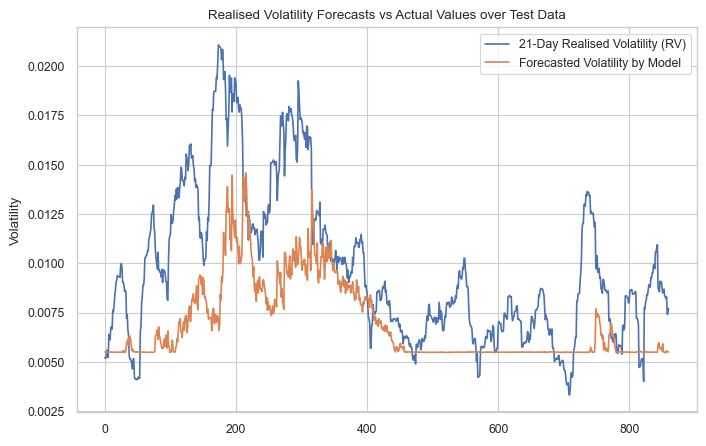

Test HMAE: 0.27266889810562134	 Test HMSE: 0.10041843354701996


In [182]:
set_seed_all()
all_gmlp_model = CustomMLP(input_size = 63, hidden_sizes = [16,10,4], 
                           output_size= 1, dropout = [0.2,0.1], model_name='GARCH-DFN_All')
all_gmlp_path , all_gdfn_test_pred, all_gdfn_test_actual = final_model_test(all_gmlp_model,
                                                                  all_train_val_dl,
                                                                  all_test_dl,
                                                                  lr = 0.001,
                                                                 best_epoch=171
                                                                 )

In [183]:
log_perf(all_gdfn_test_actual, all_gdfn_test_pred, 'G-DFN All (16,10,4 0.2,0.1 Dropout)', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  \
0                            Benchmark Model  0.002447   0.273101  0.000010   
1                         GARCH(1,1) Rolling  0.002388   0.269345  0.000009   
2                       GARCH(1,1) Expanding  0.002258   0.264538  0.000008   
3               MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   
4              LSTM (30 Hidden, 0.0 Dropout)  0.002600   0.247676  0.000013   
5  GARCH-DFN (16,8,4 with 0.2,0.1,0 Dropout)  0.002690   0.241112  0.000014   
6           GARCH-LSTM (40 16FC 0.2 dropout)  0.002376   0.226640  0.000011   
7        G-DFN All (16,10,4 0.2,0.1 Dropout)  0.003047   0.272669  0.000017   

   Test HMSE  
0   0.128265  
1   0.119719  
2   0.125679  
3   0.109418  
4   0.096490  
5   0.085636  
6   0.080455  
7   0.100418

## 2b. GARCH-LSTM + Extra Variables

Learning Rate: 0.001
Starting training...

Early stopping triggered after 81 epochs.


Training Completed in 14.57 seconds

Best Validation Loss: 0.0038520262709685732 at epoch 6


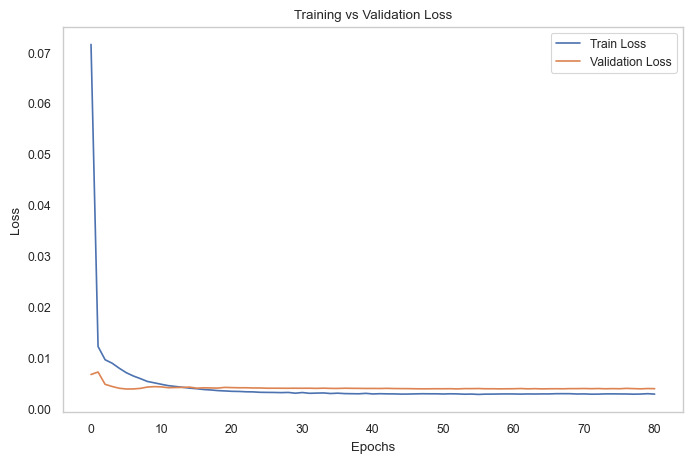

Loaded the model from StackedLSTM_All.pth


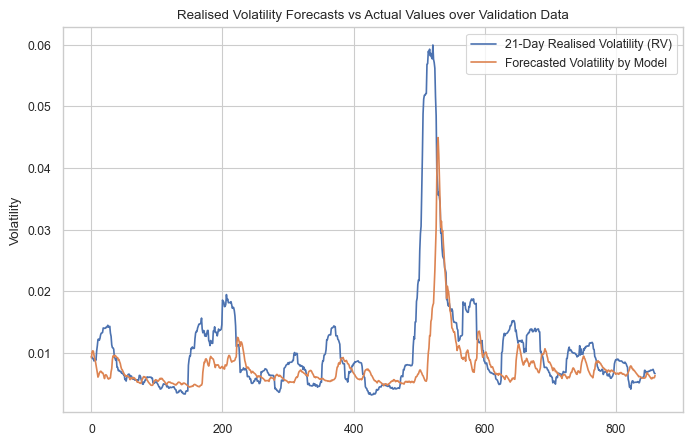

Validation HMAE: 0.3004239797592163	 Validation HMSE: 0.13637997210025787


In [184]:
set_seed_all()
glstm_all_model = StackedLSTM(3, [40], dropouts=[0.2], model_name='StackedLSTM_All', fc_hidden_size=16)

all_glstm_path = train_model(glstm_all_model, all_train_lstm_dl, all_val_lstm_dl, lr = 0.001, loss_fn='MAE', 
                             max_epochs=200)

glstm_all_model = load_best_model(glstm_all_model, all_glstm_path)

all_glstm_val_pred, all_glstm_val_actual = evaluate_model(glstm_all_model, all_val_lstm_dl)

In [185]:
log_perf(all_glstm_val_actual, all_glstm_val_pred, 'G-LSTM All (40, 0.2,16 FC 0.2 Dropout)', perf_df, True)

Model Name       MAE      HMAE       MSE  \
0                               Benchmark Model  0.005401  0.479794  0.000086   
1           GARCH(1,1) Zero Mean Rolling Window  0.004602  0.419639  0.000060   
2       GARCH(1,1) Constant Mean Rolling Window  0.004619  0.416611  0.000060   
3         GARCH(1,1) Zero Mean Expanding Window  0.004696  0.438246  0.000062   
4     GARCH(1,1) Constant Mean Expanding Window  0.004691  0.434746  0.000061   
5             MLP LR2 (14,8 , 0.2, 0.1 Dropout)  0.004109  0.313213  0.000065   
6            LSTM (30 Hidden Unit, 0.0 Dropout)  0.004103  0.307964  0.000062   
7      GARCH-DFN(16,8,4 with 0.2,0.1,0 dropout)  0.003987  0.303488  0.000065   
8   GARCH-LSTM (40 with 16 FC layer, 0.2 drop))  0.003998  0.304856  0.000060   
9                   G-DFN All (16,10,4 0.2,0.0)  0.003908  0.301788  0.000060   
10       G-LSTM All (40, 0.2,16 FC 0.2 Dropout)  0.003959  0.300424  0.000064   

        HMSE  
0   0.391833  
1   0.275677  
2   0.272802  
3   0.294949  
4   0.289284  
5   0.143210  
6   0.141672  
7   0.134122  
8   0.140719  
9   0.132446  
10  0.136380

Model Parameters: <bound method Module.parameters of StackedLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(2, 40, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=40, out_features=16, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)>
Learning Rate: 0.001
Starting training...


Training Completed in 1.30 seconds


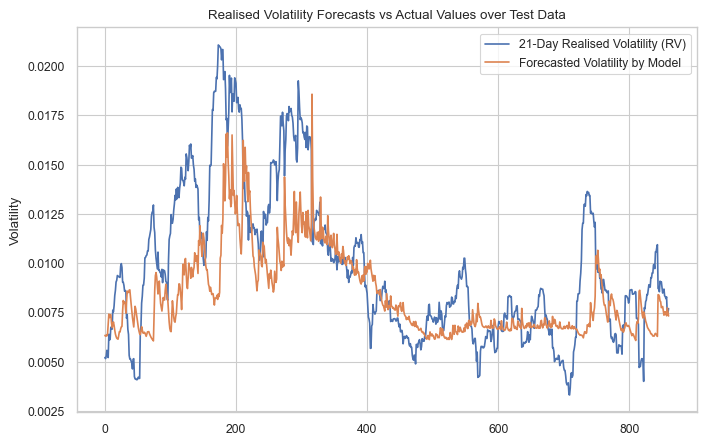

Test HMAE: 0.22530235350131989	 Test HMSE: 0.08186608552932739


In [186]:
# Build stacked model
set_seed_all()
glstm_all_model = StackedLSTM(3, [40], dropouts=[0.2], model_name='StackedLSTM_All', fc_hidden_size=16)
all_glstm_path, all_glstm_test_pred, all_glstm_test_actual = final_model_test(glstm_model, 
                                                                  garch_train_val_lstm_dl, 
                                                                  garch_test_lstm_dl, lr = 0.001, best_epoch=6)

In [187]:
log_perf(all_glstm_test_actual, all_glstm_test_pred, 'G-LSTM All (40,16 FC 0.2 Dropout)', perf_test_df, True, 'Test')

Model Name  Test MAE  Test HMAE  Test MSE  \
0                            Benchmark Model  0.002447   0.273101  0.000010   
1                         GARCH(1,1) Rolling  0.002388   0.269345  0.000009   
2                       GARCH(1,1) Expanding  0.002258   0.264538  0.000008   
3               MLP (14,8 , 0.2,0.1 Dropout)  0.003165   0.291612  0.000017   
4              LSTM (30 Hidden, 0.0 Dropout)  0.002600   0.247676  0.000013   
5  GARCH-DFN (16,8,4 with 0.2,0.1,0 Dropout)  0.002690   0.241112  0.000014   
6           GARCH-LSTM (40 16FC 0.2 dropout)  0.002376   0.226640  0.000011   
7        G-DFN All (16,10,4 0.2,0.1 Dropout)  0.003047   0.272669  0.000017   
8          G-LSTM All (40,16 FC 0.2 Dropout)  0.002320   0.225302  0.000010   

   Test HMSE  
0   0.128265  
1   0.119719  
2   0.125679  
3   0.109418  
4   0.096490  
5   0.085636  
6   0.080455  
7   0.100418  
8   0.081866

## 2e. Visualise Predictions 

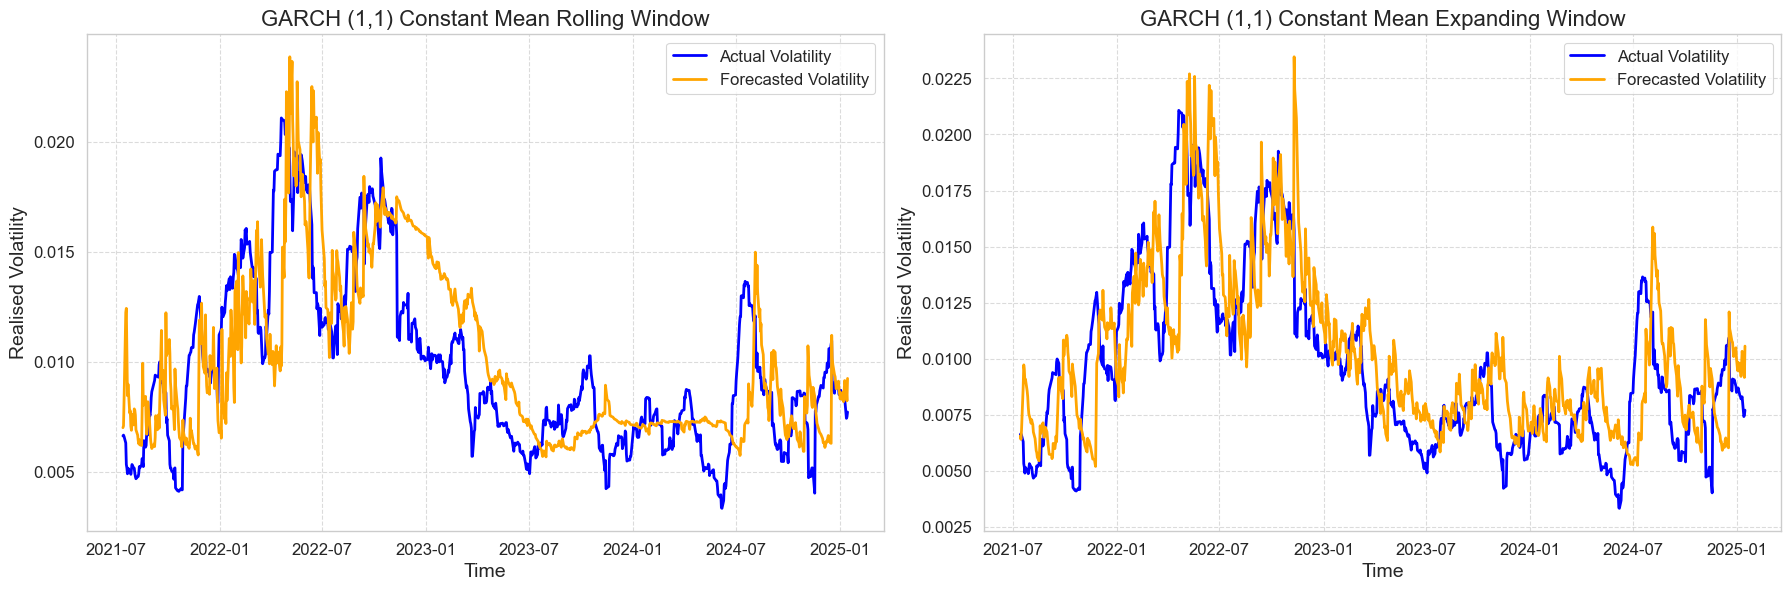

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

vis_pred(RV_test, gm_best_forecast_test['Vol-1'], 'GARCH (1,1) Constant Mean Rolling Window', axes[0])
vis_pred(RV_test, gm_best_forecast_test_exp['Vol-1'], 'GARCH (1,1) Constant Mean Expanding Window', axes[1])

plt.tight_layout()
plt.savefig('figures/GARCH_forecast_test.png', dpi =300)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

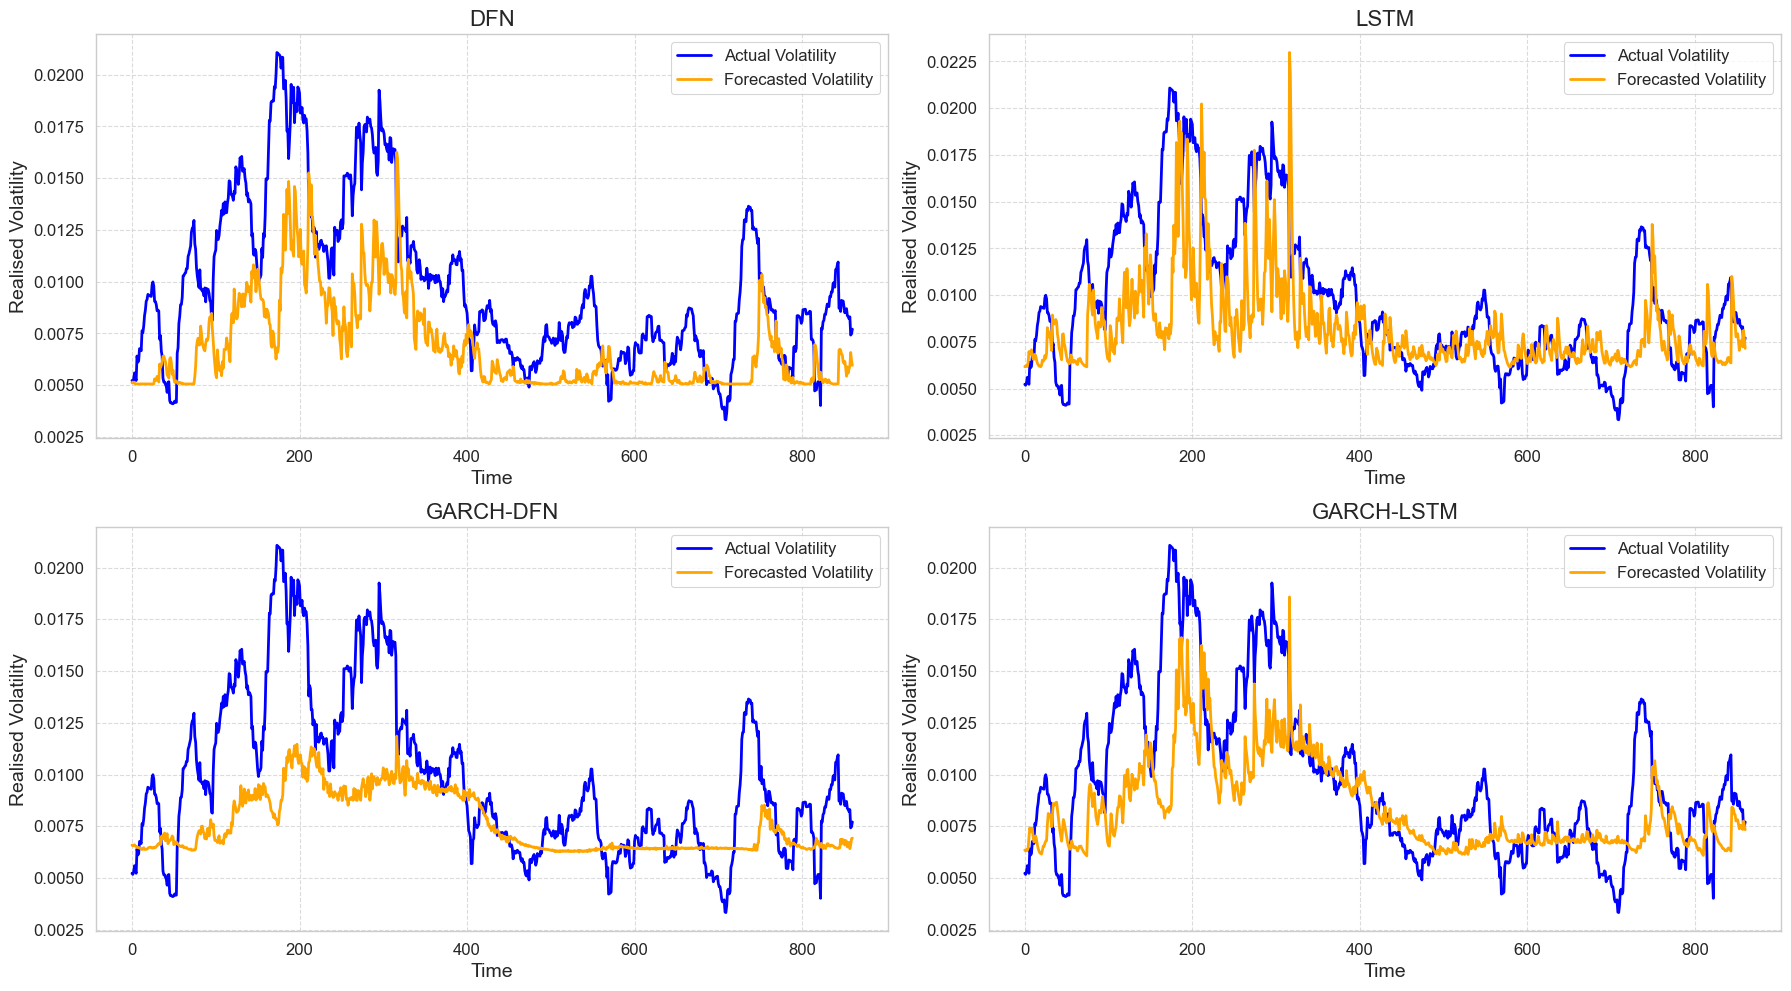

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

vis_pred(MLP_test_actual.squeeze(-1), MLP_test_pred.squeeze(-1), 'DFN', axes[0,0])
vis_pred(lstm_test_actual.squeeze(-1), lstm_test_pred.squeeze(-1), 'LSTM', axes[0,1])
vis_pred(gdfn_test_actual.squeeze(-1), gdfn_test_pred.squeeze(-1), 'GARCH-DFN', axes[1,0])
vis_pred(glstm_test_actual.squeeze(-1), all_glstm_test_pred.squeeze(-1), 'GARCH-LSTM', axes[1,1])

plt.tight_layout()
plt.savefig('figures/ML_test_plot.png', dpi =300)
plt.show

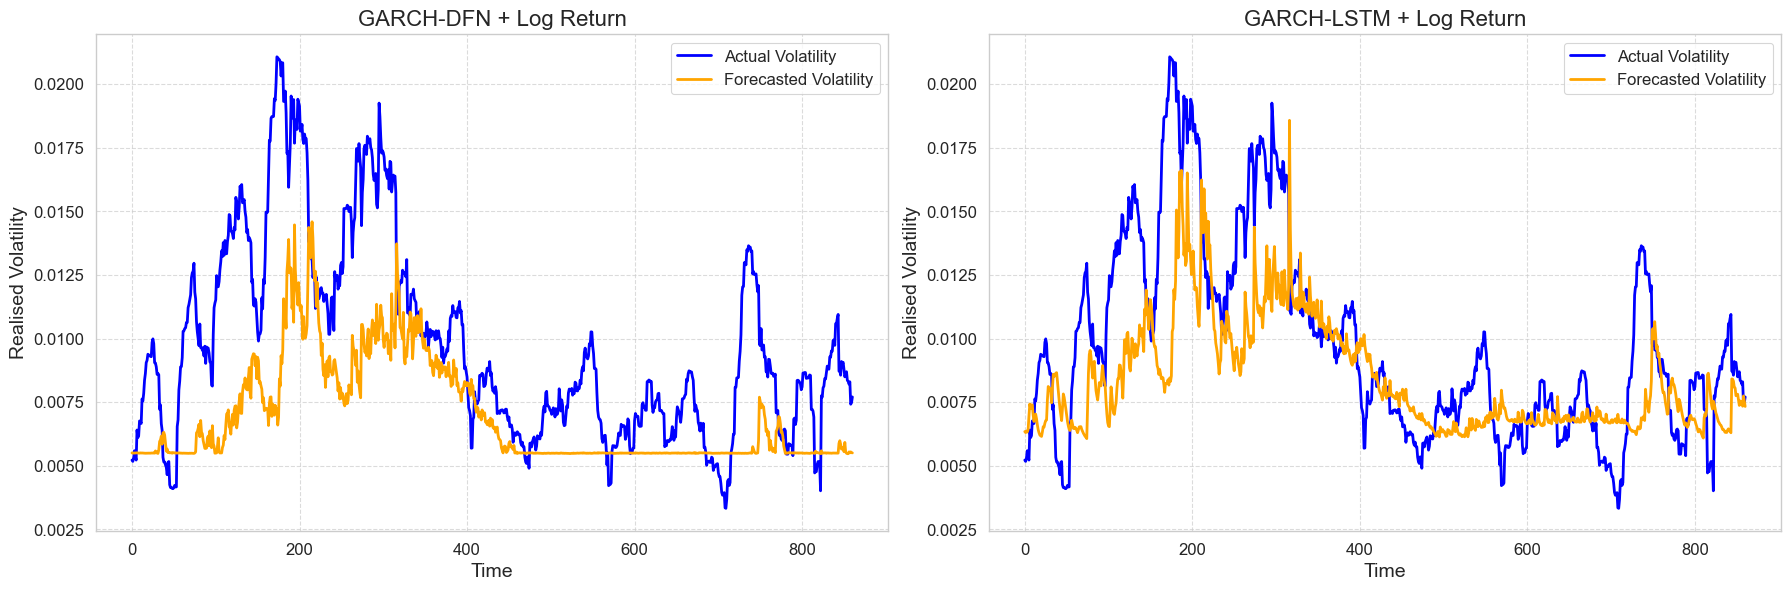

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

vis_pred(all_gdfn_test_actual.squeeze(-1), all_gdfn_test_pred.squeeze(-1), 'GARCH-DFN + Log Return', axes[0])
vis_pred(all_glstm_test_actual.squeeze(-1), all_glstm_test_pred.squeeze(-1), 'GARCH-LSTM + Log Return', axes[1])

plt.tight_layout()
plt.savefig('figures/additional_garch_plot.png', dpi = 300)
plt.show()

Use a bar chart to show the improvement of the models to baseline. 

In [212]:
perf_final_df = perf_test_df.copy()

In [213]:
new_names = np.array([
    'Benchmark Model',
    'GARCH(1,1) Rolling',
    'GARCH(1,1) Expanding',
    'DFN',
    'LSTM',
    'GARCH-DFN',
    'GARCH-LSTM',
    'LR-GARCH-DFN',
    'LR-GARCH-LSTM'
])

In [214]:
perf_final_df['Model Name'] = new_names
perf_final_df

Model Name  Test MAE  Test HMAE  Test MSE  Test HMSE
0       Benchmark Model  0.002447   0.273101  0.000010   0.128265
1    GARCH(1,1) Rolling  0.002388   0.269345  0.000009   0.119719
2  GARCH(1,1) Expanding  0.002258   0.264538  0.000008   0.125679
3                   DFN  0.003165   0.291612  0.000017   0.109418
4                  LSTM  0.002600   0.247676  0.000013   0.096490
5             GARCH-DFN  0.002690   0.241112  0.000014   0.085636
6            GARCH-LSTM  0.002376   0.226640  0.000011   0.080455
7          LR-GARCH-DFN  0.003047   0.272669  0.000017   0.100418
8         LR-GARCH-LSTM  0.002320   0.225302  0.000010   0.081866

In [226]:
perf_final_df.to_excel('figures/final_model_loss.xlsx', index = False)

In [222]:
def plot_hmetric_improvement_dodge(df):
    df = df.copy()
    
    # Get benchmark row
    benchmark = df[df['Model Name'] == 'Benchmark Model'].iloc[0]

    # Calculate improvement
    df['HMAE Improvement (%)'] = 100 * (benchmark['Test HMAE'] - df['Test HMAE']) / benchmark['Test HMAE']
    df['HMSE Improvement (%)'] = 100 * (benchmark['Test HMSE'] - df['Test HMSE']) / benchmark['Test HMSE']

    # Remove Benchmark from plotting
    df_filtered = df[df['Model Name'] != 'Benchmark Model']

    # Reshape to long format
    df_long = df_filtered.melt(
        id_vars='Model Name',
        value_vars=['HMAE Improvement (%)', 'HMSE Improvement (%)'],
        var_name='Metric',
        value_name='Improvement (%)'
    )

    # Plot with Seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_long, x='Model Name', y='Improvement (%)', hue='Metric', dodge=True,  palette={
            'HMAE Improvement (%)': 'orange',
            'HMSE Improvement (%)': 'blue'
        })
    plt.title('Improvement from Benchmark Model (HMAE & HMSE)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title='Metric')
    plt.savefig('figures/baseline_impr.png', dpi = 300)
    plt.show()

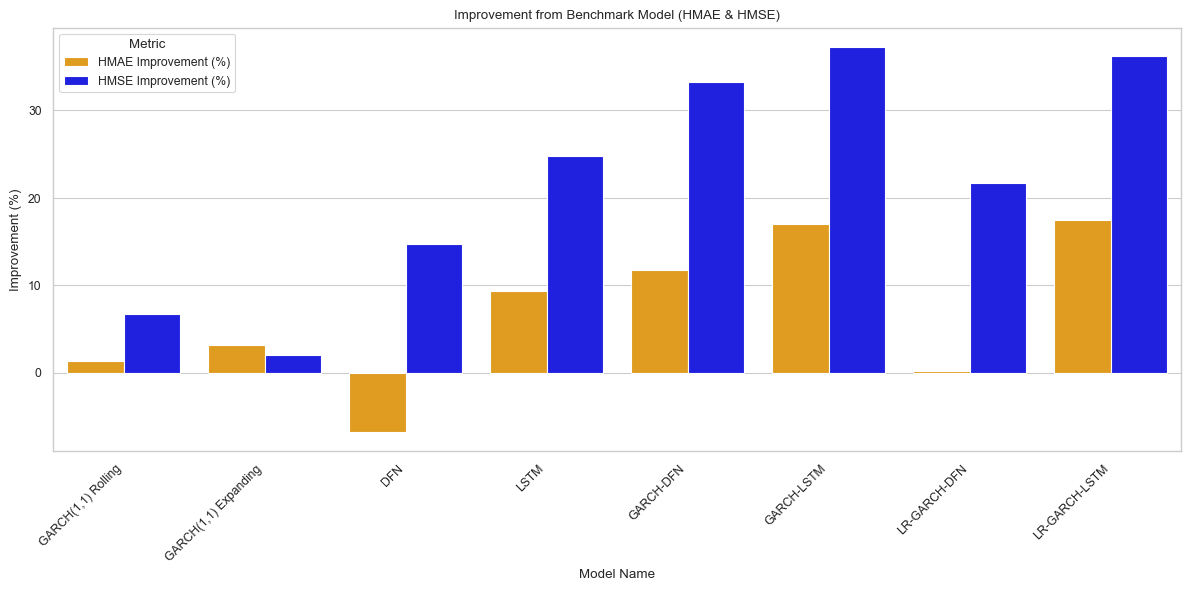

In [223]:
plot_hmetric_improvement_dodge(perf_final_df)

Bar chart showing improvement in HMAE and HMSE of neural networks compared to GARCH rolling window. 

In [224]:
def plot_garch_dfn_lstm_improvement(df):
    
    df=df.copy()
    
    metrics = ['Test MAE', 'Test HMAE', 'Test MSE', 'Test HMSE']
    
    # Extract rows
    dfn = df[df['Model Name'].str.contains('DFN')].iloc[0]
    lstm = df[df['Model Name'].str.contains('DFN')].iloc[0]
    gdfn = df[df['Model Name'].str.contains('GARCH-DFN')].iloc[0]
    glstm = df[df['Model Name'].str.contains('GARCH-LSTM')].iloc[0]


    data = []
    for metric in metrics:
        dfn_val = dfn[metric]
        lstm_val = lstm[metric]
        gdfn_val = gdfn[metric]
        glstm_val = glstm[metric]

        data.append({'Metric': metric.replace('Test ', ''), 'Model': 'GARCH-DFN', 'Improvement (%)': 100 * (dfn_val - gdfn_val) / dfn_val})
        data.append({'Metric': metric.replace('Test ', ''), 'Model': 'GARCH-LSTM', 'Improvement (%)': 100 * (lstm_val - glstm_val) / lstm_val})

    imp_df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x='Metric', y='Improvement (%)', hue='Model', dodge=True, palette={'GARCH-DFN':'blue','GARCH-LSTM':'orange'})
    plt.title('Improvement by adding GARCH')
    plt.tight_layout()
    plt.savefig('figures/garch_improvement.png', dpi = 300)
    plt.show()

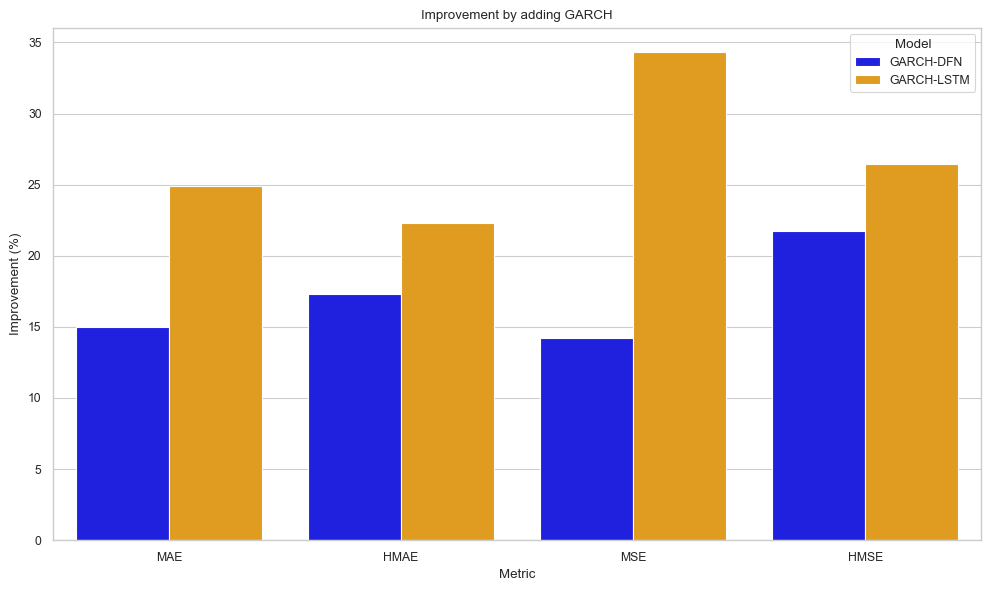

In [225]:
plot_garch_dfn_lstm_improvement(perf_final_df)